In [2]:
!pip install plotly==5.14.1
!pip install "jupyterlab>=3" "ipywidgets>=7.6"
!pip install jupyter-dash
!pip install -U kaleido

In [1]:
import numpy as np
import pandas as pd
import openpyxl as xl
import FILibExcel
import seaborn as sns
import matplotlib.pyplot as plt

# Data Processing

In [2]:
excel_path = r"../../static/mock/titanium sols.xlsx"
artifacts_path = r"../../static/mock/soles_artifacts/first_dataset/"

In [3]:
tables_dict = FILibExcel.get_all_tables(file_name=excel_path)
df = tables_dict["Table1"]['dataframe']
df = df.fillna(value=0)


worksheet name: Sheet1
tables in worksheet: 0

worksheet name: Experiment_data
tables in worksheet: 1
table name: Table1

worksheet name: Experiment_data_2
tables in worksheet: 1
table name: Table2

worksheet name: Experiment_data_3
tables in worksheet: 1
table name: Table3


In [4]:
df.shape

(71, 9)

In [5]:
df.head()

,Composition mixtures,"t, °С","t, min","с(acid), M","с(Ti4+), M",ultrasound,"d, nm","Contents, %","Stability of sols, days"
0,H2O + HNO3 + TiIPO + ButOH,45,60,4,0.5,0,618.5,100.0,16
1,H2O + HNO3 + TiIPO + ButOH,80,10,4,0.5,0,978.1,100.0,16
2,H2O + HNO3 + TiIPO + ButOH,45,20,4,0.5,0,2.0,100.0,90
3,H2O + HNO3 + TiIPO + ButOH,45,20,4,0.47,0,2.628,100.0,60
4,H2O + HNO3 + TiIPO + IPOОН,50,20,4,0.2,0,1712,100.0,16


In [6]:
composition_mixtures_dict = {
    'H2O + HNO3 + TiIPO + ButOH': 1,
    'H2O + HNO3 + TiIPO + IPOОН': 2,
    'H2O + HNO3 + ТiBut + ButOH': 3,
    'H2O + TiOSO₄´xH2SO4´yH2O': 4,
}
df = df.replace(composition_mixtures_dict)

In [7]:
df.astype('float').describe().T

,count,mean,std,min,25%,50%,75%,max
Composition mixtures,71.0,3.183099,0.960801,1.00,2.0000,4.000,4.00,4.00
"t, °С",71.0,62.619718,19.485061,20.00,45.0000,71.000,80.00,93.00
"t, min",71.0,30.633803,30.194720,8.00,11.0000,12.000,57.00,130.00
"с(acid), M",71.0,0.919155,1.468489,0.10,0.1000,0.100,0.53,4.00
"с(Ti4+), M",71.0,0.427042,0.195115,0.14,0.2000,0.520,0.60,0.62
ultrasound,71.0,0.169014,0.413553,0.00,0.0000,0.000,0.00,1.50
"d, nm",71.0,669.500366,897.495190,0.70,2.0495,2.763,2000.00,2159.00
"Contents, %",71.0,97.030986,14.362984,0.50,100.0000,100.000,100.00,100.00
"Stability of sols, days",71.0,25.577465,24.248807,0.00,2.0000,16.000,40.00,90.00


In [8]:
df = df.drop('ultrasound ', axis=1)
df = df.astype('float')
df['Composition mixtures'] = df['Composition mixtures'].astype('int')

In [9]:
df.dtypes

Composition mixtures         int64
t, °С                      float64
t, min                     float64
с(acid), M                 float64
с(Ti4+), M                 float64
d, nm                      float64
Contents, %                float64
Stability of sols, days    float64
dtype: object

In [10]:
X = df.drop(['Contents, %', 'd, nm', 'Stability of sols, days', 'Composition mixtures'], axis=1)
y_days = df['Stability of sols, days']
y_d = df['d, nm']
y_content = df['Contents, %']

# Linear regression for coafitionts predictions

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

parameters = {'fit_intercept': [True, False]}

model = LinearRegression()
clf = GridSearchCV(
    model, 
    parameters, 
    cv=5, 
    scoring='neg_mean_absolute_error',
    refit=True,
    n_jobs=-1)
clf.fit(X, y_days)
best_linear_regression_days = clf.best_estimator_
print(clf.best_score_)
print(clf.best_params_)
print(best_linear_regression_days.coef_)

-14.57958376118736
{'fit_intercept': False}
[-0.22255045 -0.12409522  6.46084839 87.510192  ]


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

parameters = {'fit_intercept': [True, False]}

model = LinearRegression()
clf = GridSearchCV(
    model, 
    parameters, 
    cv=5, 
    scoring='neg_mean_absolute_error',
    refit=True,
    n_jobs=-1)
pipe = make_pipeline(StandardScaler(), clf)
pipe.fit(X, y_d)
best_linear_regression_d = clf.best_estimator_
print(clf.best_score_)
print(clf.best_params_)
print(best_linear_regression_d.coef_)

-369.4249748277499
{'fit_intercept': True}
[ -10.22916906 -239.54262288 -131.75458639 -908.77443277]


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

parameters = {'fit_intercept': [True, False]}

model = LinearRegression()
clf = GridSearchCV(
    model, 
    parameters, 
    cv=5, 
    scoring='neg_mean_absolute_error',
    refit=True,
    n_jobs=-1)
clf.fit(X, y_content)
best_linear_regression_content = clf.best_estimator_
print(clf.best_score_)
print(clf.best_params_)
print(best_linear_regression_content.coef_)

-7.402350072941147
{'fit_intercept': True}
[ -0.12629949  -0.28033645  -2.57628363 -17.31077647]


# Optimisation with NSGA2 algorithm

In [16]:
!pip install -U pymoo

In [17]:
(best_linear_regression_content.coef_ * np.array([20, 1, 0.107, 0.232])).sum() + best_linear_regression_content.intercept_

116.18994385781558

In [18]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter


class SoleProblem(ElementwiseProblem):
    def __init__(self, coefs):
        self.coefs = coefs
        super().__init__(n_var=4, n_obj=3, n_ieq_constr=4,
                         xl=np.array([10, 1, 0.1, 0.1]),
                         xu=np.array([100, 130, 4, 0.7]) )

    def _evaluate(self, x, out, *args, **kwargs):
        fs = []
        gs = []
        for coef in self.coefs:
            f = coef[-1]
            for i in range(0, len(coef) - 1):
                f += x[i] * coef[i]    
            fs.append(f)
        out["F"] = fs
        out["G"] = [fs[0], -fs[1] + 0.7, fs[2], -fs[2] - 140]


problem = SoleProblem(
    [-np.append(best_linear_regression_days.coef_, best_linear_regression_days.intercept_),
     np.append(best_linear_regression_d.coef_, best_linear_regression_d.intercept_),
     -np.append(best_linear_regression_content.coef_, best_linear_regression_content.intercept_)
    ])

algorithm = NSGA2(pop_size=100)

res = minimize(problem,
               algorithm,
               ("n_gen", 500),
               verbose=False,
               seed=1)

In [19]:
# import plotly.express as px
# F = res.F
# fig = px.scatter(x=-F[:, 0], y=F[:, 1], labels={"x": "Stability of sols, days", "y": "d, nm"})
# fig.write_html(artifacts_path + 'first_figure.html', auto_open=True)
# fig.write_image(artifacts_path + 'optimal.png')

In [20]:
for f, x in zip(res.F, res.X):
    print(f'For getting stability days = {round(-f[0], 3)}, diameter = {round(f[1], 3)} and content = {round(-f[2], 3)} use:')
    print(f'\ttemperature = {round(x[0], 3)}')
    print(f'\ttime = {round(x[1], 3)}')
    print(f'\tc(acid) = {round(x[2], 3)}')
    print(f'\tc(Ti) = {round(x[3], 3)}')

For getting stability days = 7.048, diameter = 223.613 and content = 119.756 use:
	temperature = 10.0
	time = 1.0
	c(acid) = 0.1
	c(Ti) = 0.1
For getting stability days = 27.761, diameter = 0.7 and content = 115.503 use:
	temperature = 10.018
	time = 1.0
	c(acid) = 0.217
	c(Ti) = 0.328
For getting stability days = 5.184, diameter = 1.664 and content = 118.575 use:
	temperature = 18.052
	time = 1.583
	c(acid) = 0.1
	c(Ti) = 0.1
For getting stability days = 28.503, diameter = 0.714 and content = 115.51 use:
	temperature = 10.0
	time = 1.0
	c(acid) = 0.101
	c(Ti) = 0.345
For getting stability days = 14.45, diameter = 118.002 and content = 118.252 use:
	temperature = 10.017
	time = 1.118
	c(acid) = 0.1
	c(Ti) = 0.185
For getting stability days = 7.488, diameter = 213.114 and content = 119.644 use:
	temperature = 10.108
	time = 1.019
	c(acid) = 0.101
	c(Ti) = 0.105
For getting stability days = 23.171, diameter = 55.503 and content = 116.558 use:
	temperature = 10.045
	time = 1.0
	c(acid) = 

# Random forest feature importance prediction

In [21]:
!pip install xgboost

In [11]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb 

In [12]:
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]


In [13]:
def draw_importance(importances, model_name, columns=X.columns):
    features = {}
    color1 = "#2D466D"
    color2 = "#A2B0C5"
    for i, feature in enumerate(columns):
        features[f"f{i+1}"] = feature

    indices = np.argsort(importances)[::-1]
    num_to_plot = len(columns)
    feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

    print("Feature ranking:")
    for f in range(num_to_plot):
        print(
            "%d. %s %f "
            % (f + 1, features["f" + str(feature_indices[f])], importances[indices[f]])
        )
    plt.figure(figsize=(20, 10))
    bars = plt.bar(
        range(num_to_plot),
        importances[indices[:num_to_plot]],
        color=get_color_gradient(color1, color2, num_to_plot),
        align="center",
    )
    ticks = plt.xticks(range(num_to_plot), feature_indices, fontsize=22)
    plt.yticks(fontsize=22)
    plt.xlim([-1, num_to_plot])
    plt.legend(bars, [u"".join(features["f" + str(i)]) for i in feature_indices], fontsize="24");
    plt.title(f"Feature importance in {model_name}", fontsize=22)
    plt.savefig(f'{artifacts_path}{model_name}.eps', format='eps', dpi=600, bbox_inches='tight', transparent="True", pad_inches=0)
    

In [14]:
def draw_random_forest(X, y, name):
    parameters = {
        'n_estimators': range(100, 500, 100),
        'max_depth': [None] + list(range(3, 11, 2))}

    model = RandomForestRegressor(random_state=42)
    clf = GridSearchCV(
        model, 
        parameters, 
        cv=5, 
        scoring='neg_mean_absolute_error',
        refit=True,
        n_jobs=-1)
    clf.fit(X, y)
    best_random_forest = clf.best_estimator_
    print(clf.best_score_)
    print(clf.best_params_)
    draw_importance(best_random_forest.feature_importances_, f"Random forest {name}")

In [15]:
def draw_gradient_boosting(X, y, name):
    parameters = {
        'learning_rate': [0.5, 0.25, 0.1, 0.05, 0.01],
        'n_estimators': [4, 8, 16, 32, 64, 128],
        'max_depth': range(1, 18, 2)}

    model = GradientBoostingRegressor(random_state=42)
    clf = GridSearchCV(
        model, 
        parameters, 
        cv=5, 
        scoring='neg_mean_absolute_error',
        refit=True,
        n_jobs=-1)
    clf.fit(X, y)
    best_gradient_boost = clf.best_estimator_
    print(clf.best_score_)
    print(clf.best_params_)
    draw_importance(best_gradient_boost.feature_importances_, f"Gradient boost {name}")

In [16]:
def draw_xgboost(X, y, name):
    parameters = {
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.5, 1, 1.5, 2, 2.5,],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
    }

    model = xgb.XGBRegressor(learning_rate=0.02, n_estimators=600, nthread=1, seed=0)
    clf = GridSearchCV(
        model, 
        parameters, 
        cv=5, 
        scoring='neg_mean_absolute_error',
        refit=True,
        n_jobs=-1)
    clf.fit(X, y)
    best_xgboost = clf.best_estimator_
    print(clf.best_score_)
    print(clf.best_params_)
    draw_importance(best_xgboost.feature_importances_, f"XGboost {name}")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


-10.470757823129254
{'max_depth': 7, 'n_estimators': 100}
Feature ranking:
1. с(Ti4+), M 0.451043 
2. t, min 0.258712 
3. t, °С 0.225146 
4. с(acid), M 0.065100 


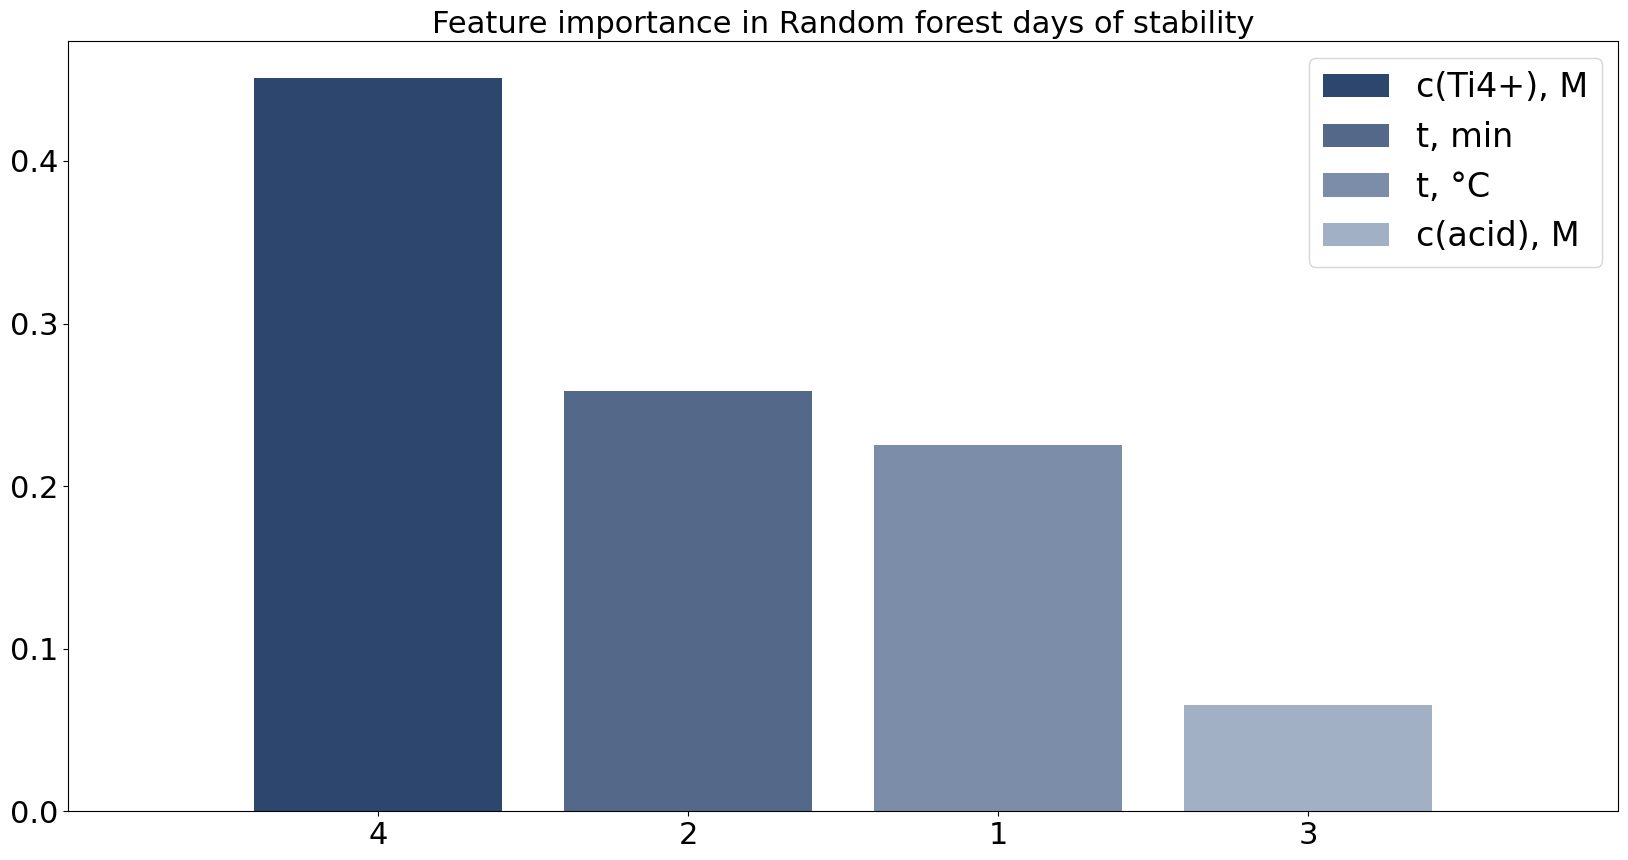

In [28]:
draw_random_forest(X, y_days, "days of stability")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


-10.050344067701214
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 128}
Feature ranking:
1. t, min 0.480931 
2. t, °С 0.346223 
3. с(Ti4+), M 0.130400 
4. с(acid), M 0.042446 


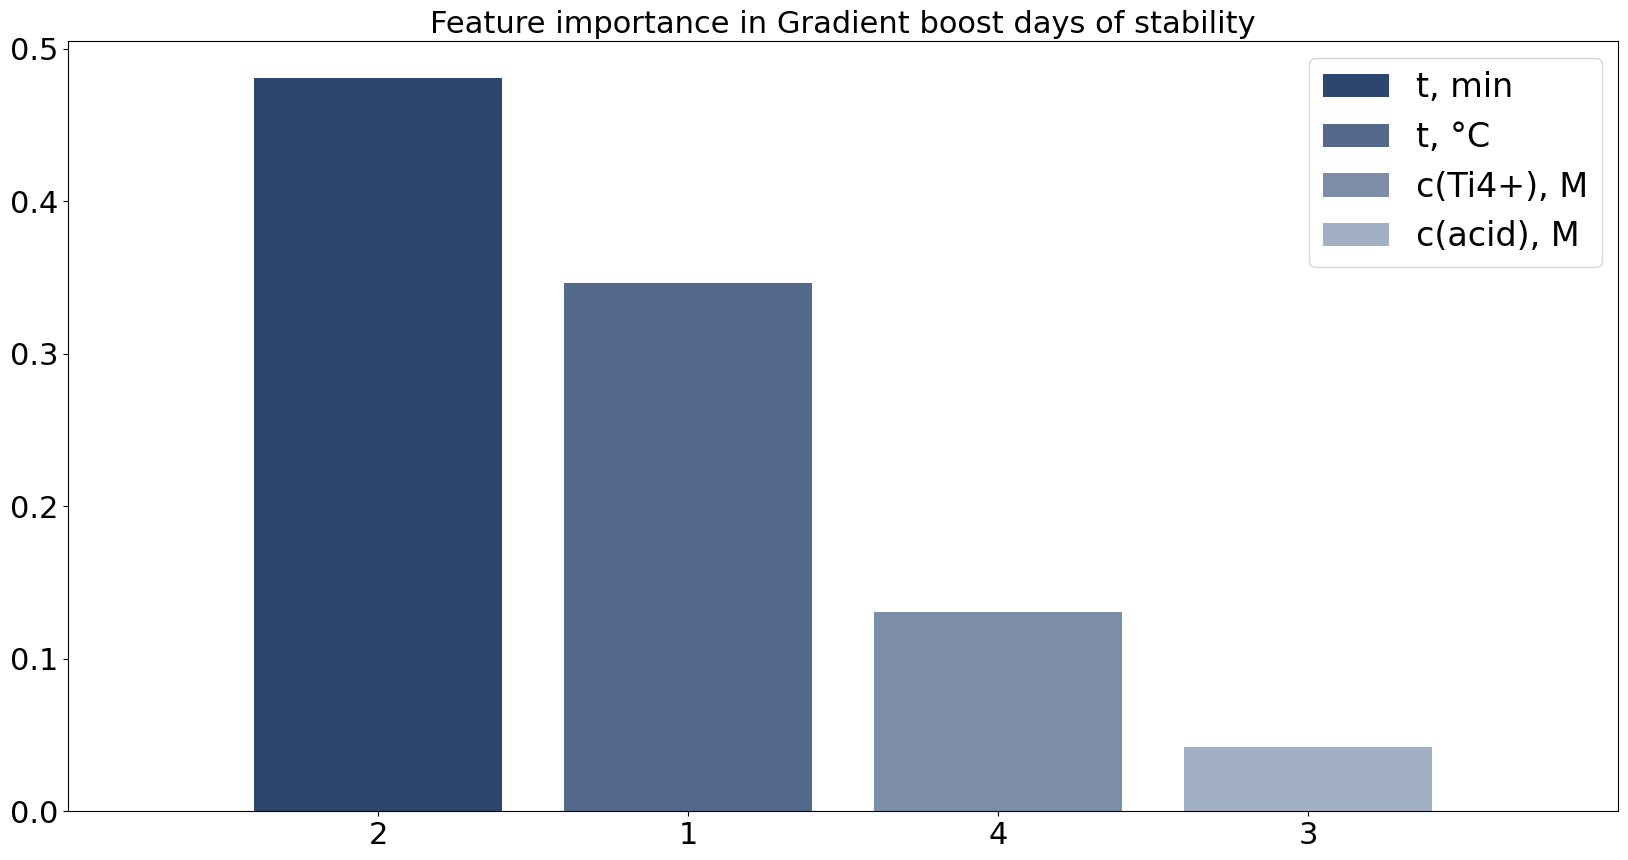

In [29]:
draw_gradient_boosting(X, y_days, "days of stability")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


-9.697281605289096
{'colsample_bytree': 1.0, 'gamma': 2.5, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.6}
Feature ranking:
1. с(Ti4+), M 0.455370 
2. t, min 0.285037 
3. t, °С 0.132387 
4. с(acid), M 0.127205 


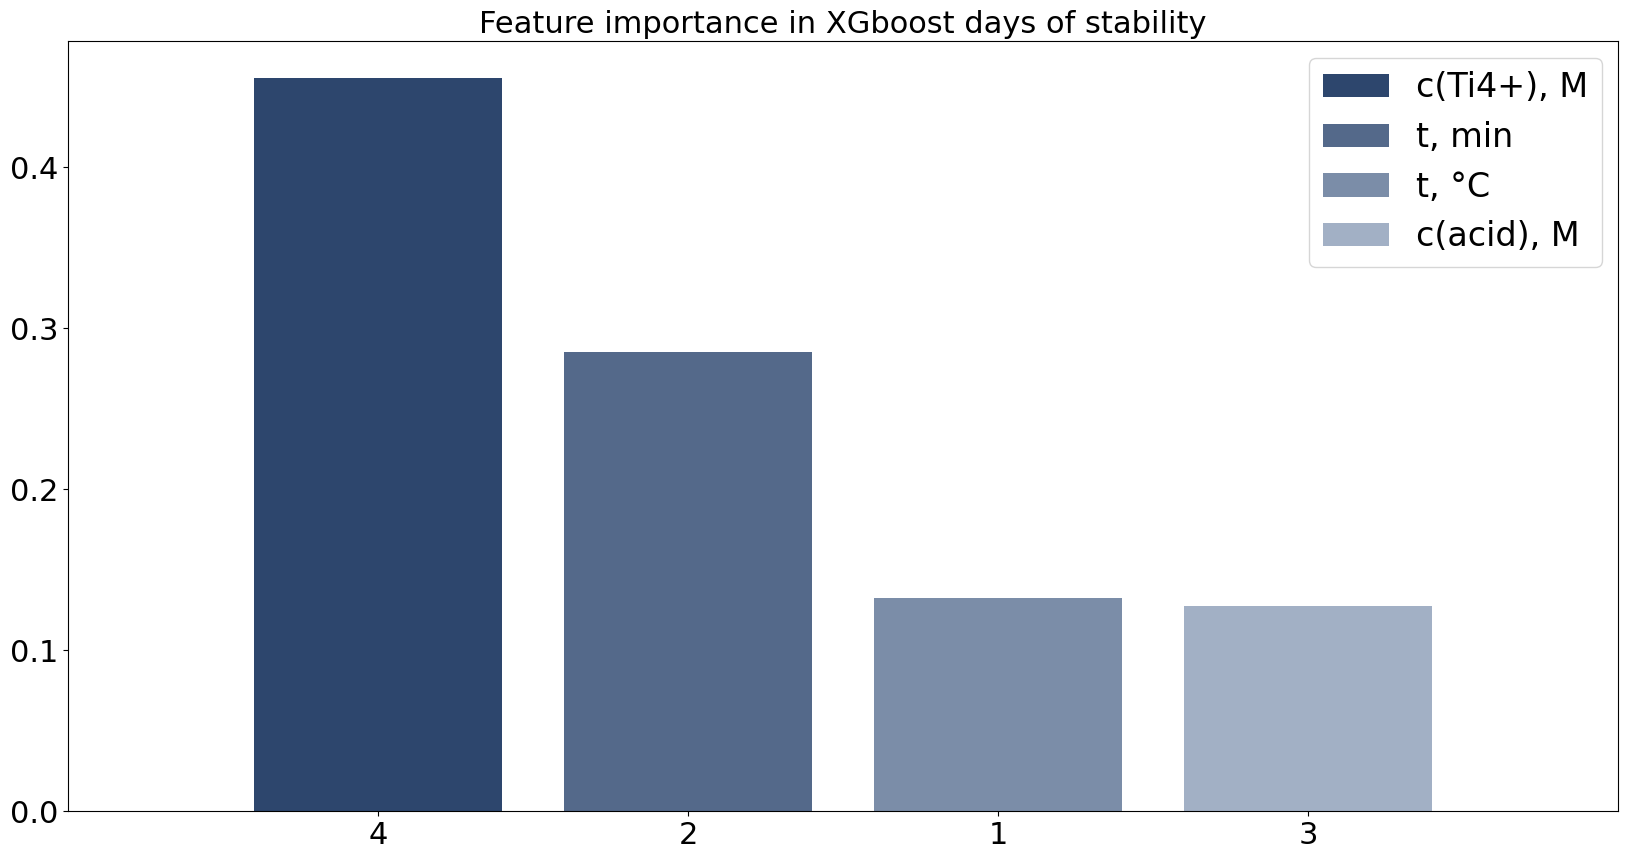

In [30]:
draw_xgboost(X, y_days, "days of stability")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


-415.865398537504
{'max_depth': 9, 'n_estimators': 200}
Feature ranking:
1. с(Ti4+), M 0.616311 
2. с(acid), M 0.181579 
3. t, min 0.122824 
4. t, °С 0.079287 


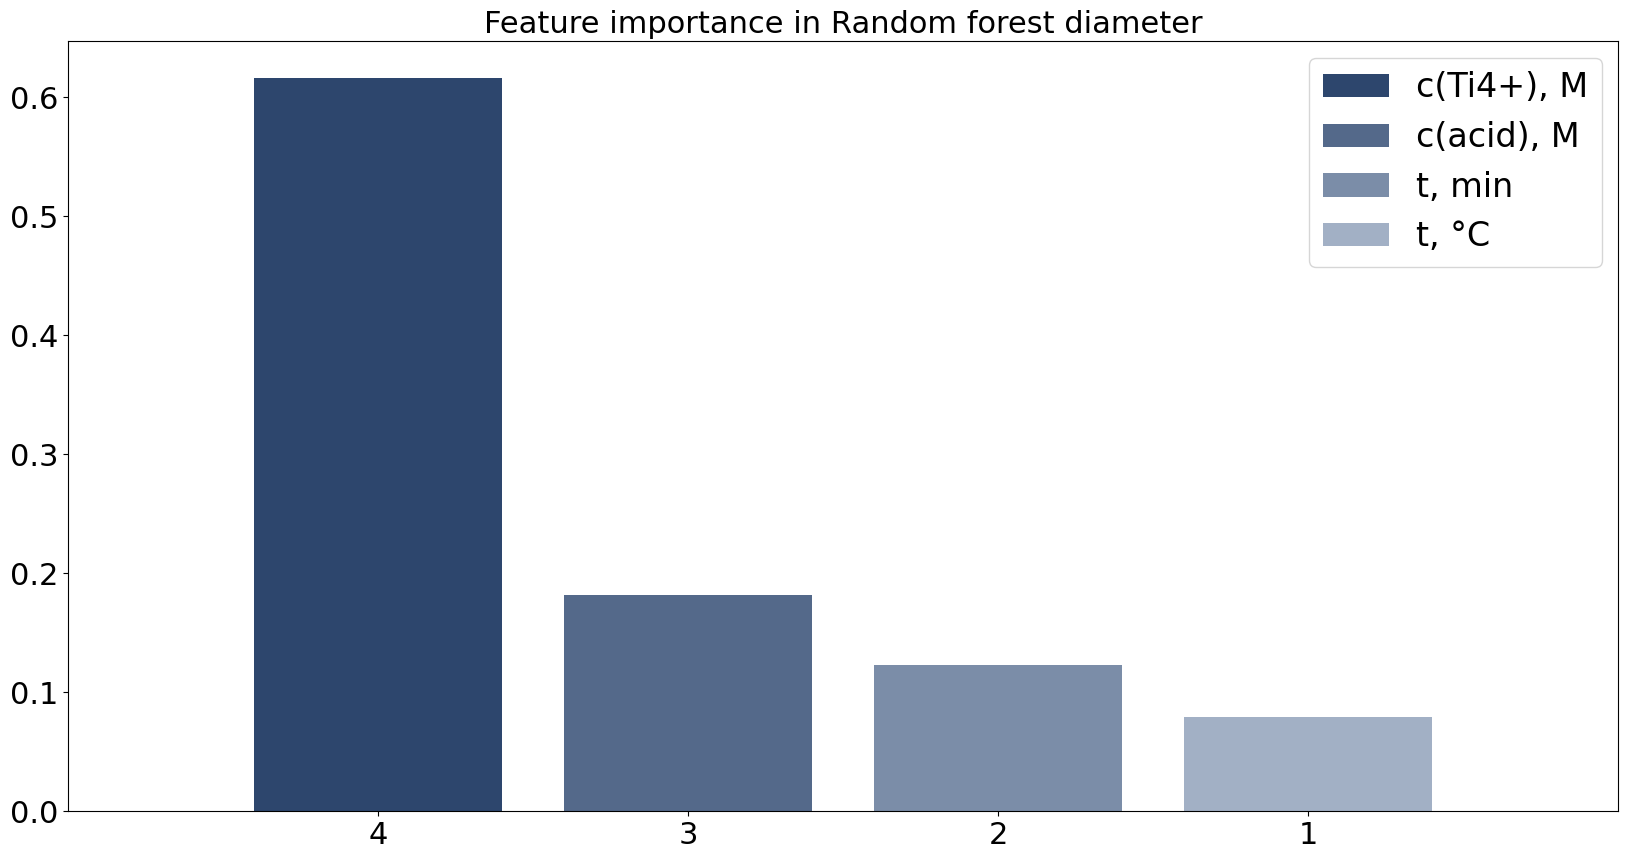

In [31]:
draw_random_forest(X, y_d, "diameter")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


-398.9535834773643
{'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 64}
Feature ranking:
1. с(Ti4+), M 0.779142 
2. с(acid), M 0.172293 
3. t, min 0.048565 
4. t, °С 0.000000 


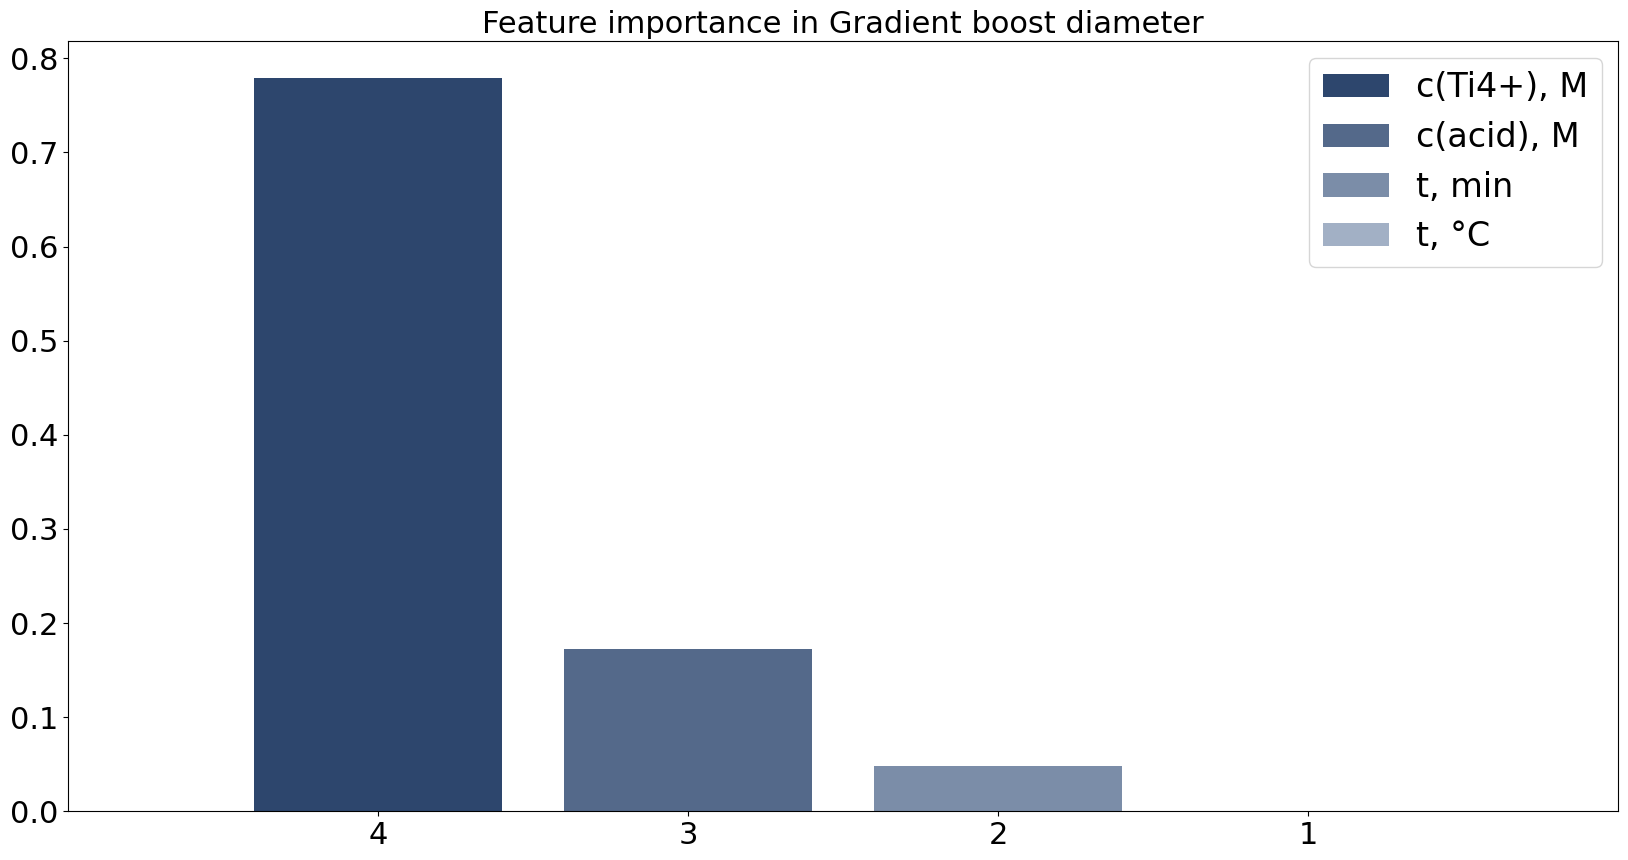

In [32]:
draw_gradient_boosting(X, y_d, "diameter")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


-369.8864989431181
{'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.6}
Feature ranking:
1. с(Ti4+), M 0.591110 
2. с(acid), M 0.246893 
3. t, min 0.097436 
4. t, °С 0.064561 


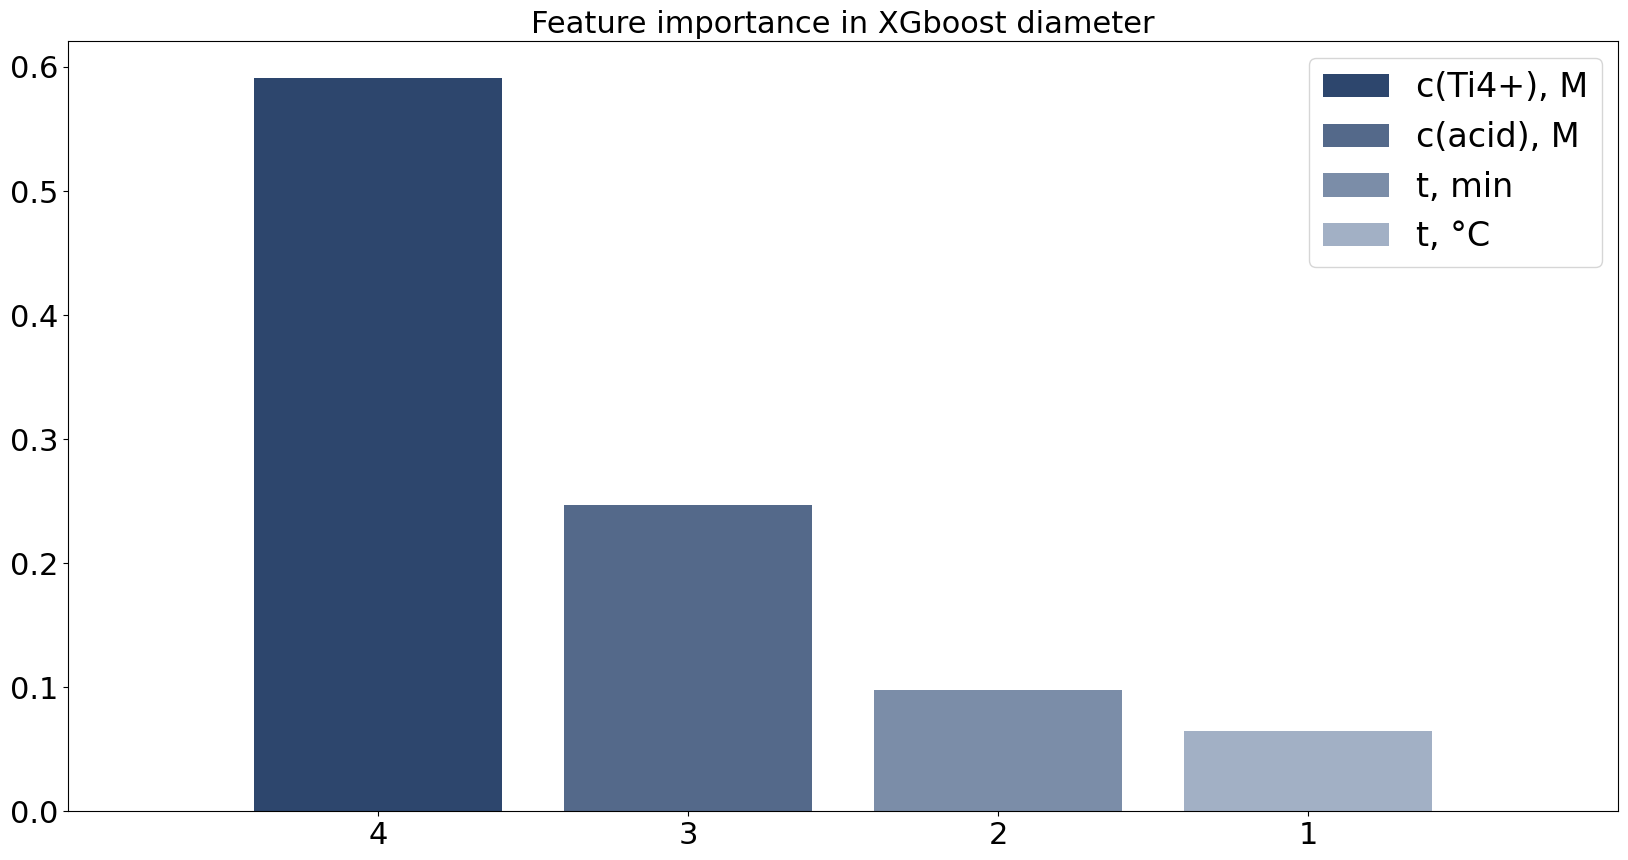

In [33]:
draw_xgboost(X, y_d, "diameter")

# Results

In [11]:
df = df.rename(columns={'t, °С': 'T, °С'})
df = df.rename(columns={'с(Ti4+), M': r'с(Ti$^{4+}$), M'})
df = df.rename(columns={'Composition mixtures': 'Mixture composition'})

In [12]:
new_col = []
for elem in df['d, nm']:
    if elem > 2000:
        new_col.append(5)
    elif elem > 1000:
        new_col.append(4)
    elif elem > 400:
        new_col.append(3)
    elif elem > 2:
        new_col.append(2)
    elif elem > 1:
        new_col.append(1)
    else:
        new_col.append(0)
df['d_categorical'] = new_col

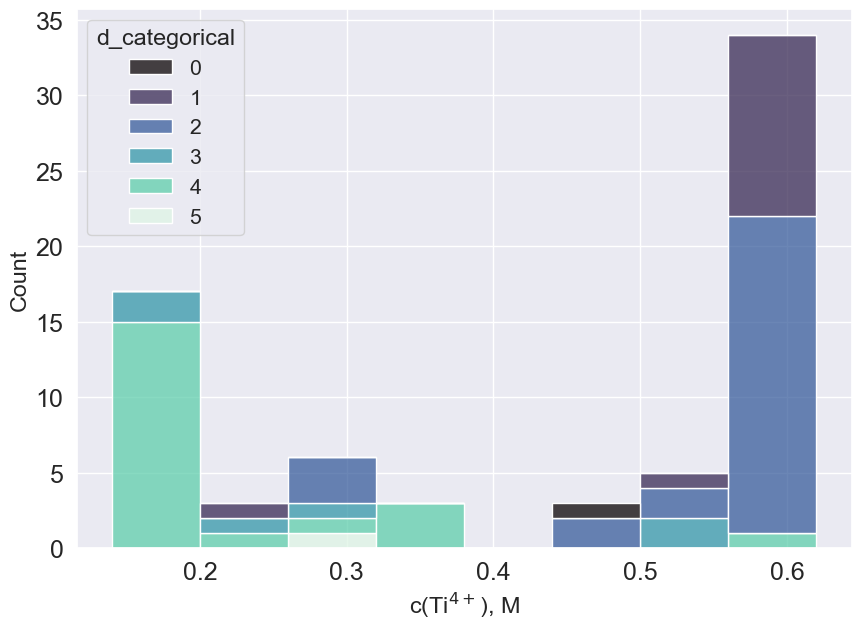

In [13]:
sns.set(font_scale=1.4)
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ax.tick_params(axis='both', labelsize=18)
sns.histplot(df, x=r'с(Ti$^{4+}$), M', hue='d_categorical', multiple="stack", palette='mako')

plt.show()

In [14]:
from matplotlib.offsetbox import AnchoredText

def draw_hists(df, hue, name, hue_order=None, discrete_save=False):
    fontdict={
        'weight': 'bold',
        'size': 20,
    }
    fig, axes = plt.subplots(ncols=2, nrows=3)
    fig.set_size_inches(20, 25)
    sns.set(font_scale=1.4)
    titles = ['a', 'b', 'c', 'd', 'e']
    index = 0
    if discrete_save:
        plt.show()

    for col, ax in zip(['T, °С', 't, min', 'с(acid), M', r'с(Ti$^{4+}$), M', 'Mixture composition'], axes.flat):
        if discrete_save:
            plt.gcf().set_size_inches(10, 7)
            ax = plt.subplot()
        else:
            txt = AnchoredText(titles[index], loc="lower right", pad=0.25, borderpad=0, prop=dict(fontsize="large"))
            ax.add_artist(txt)
        ax.tick_params(axis='both', labelsize=20, width=5)
        ax.set_xlabel(col, fontdict=fontdict)
        ax.set_ylabel('Count', fontdict=fontdict)
        if col == 'Mixture composition':
            ax.set_xticks([1, 2, 3, 4])
            sns.histplot(df, x=col, hue=hue, hue_order=hue_order, multiple="stack", palette='mako', ax=ax, discrete=True, shrink=.7)
        else:
            sns.histplot(df, x=col, hue=hue, hue_order=hue_order, multiple="stack", palette='mako', ax=ax)
        index += 1
        if discrete_save:
            plt.savefig(artifacts_path + f'first_stage_{name}_{col}.png', format='png', dpi=600)
            plt.show()

    fig.subplots_adjust(hspace=0.15)
    axes[-1, -1].axis('off')
    plt.savefig(artifacts_path + f'first_stage_{name}.png', format='png', dpi=600)
    plt.show()


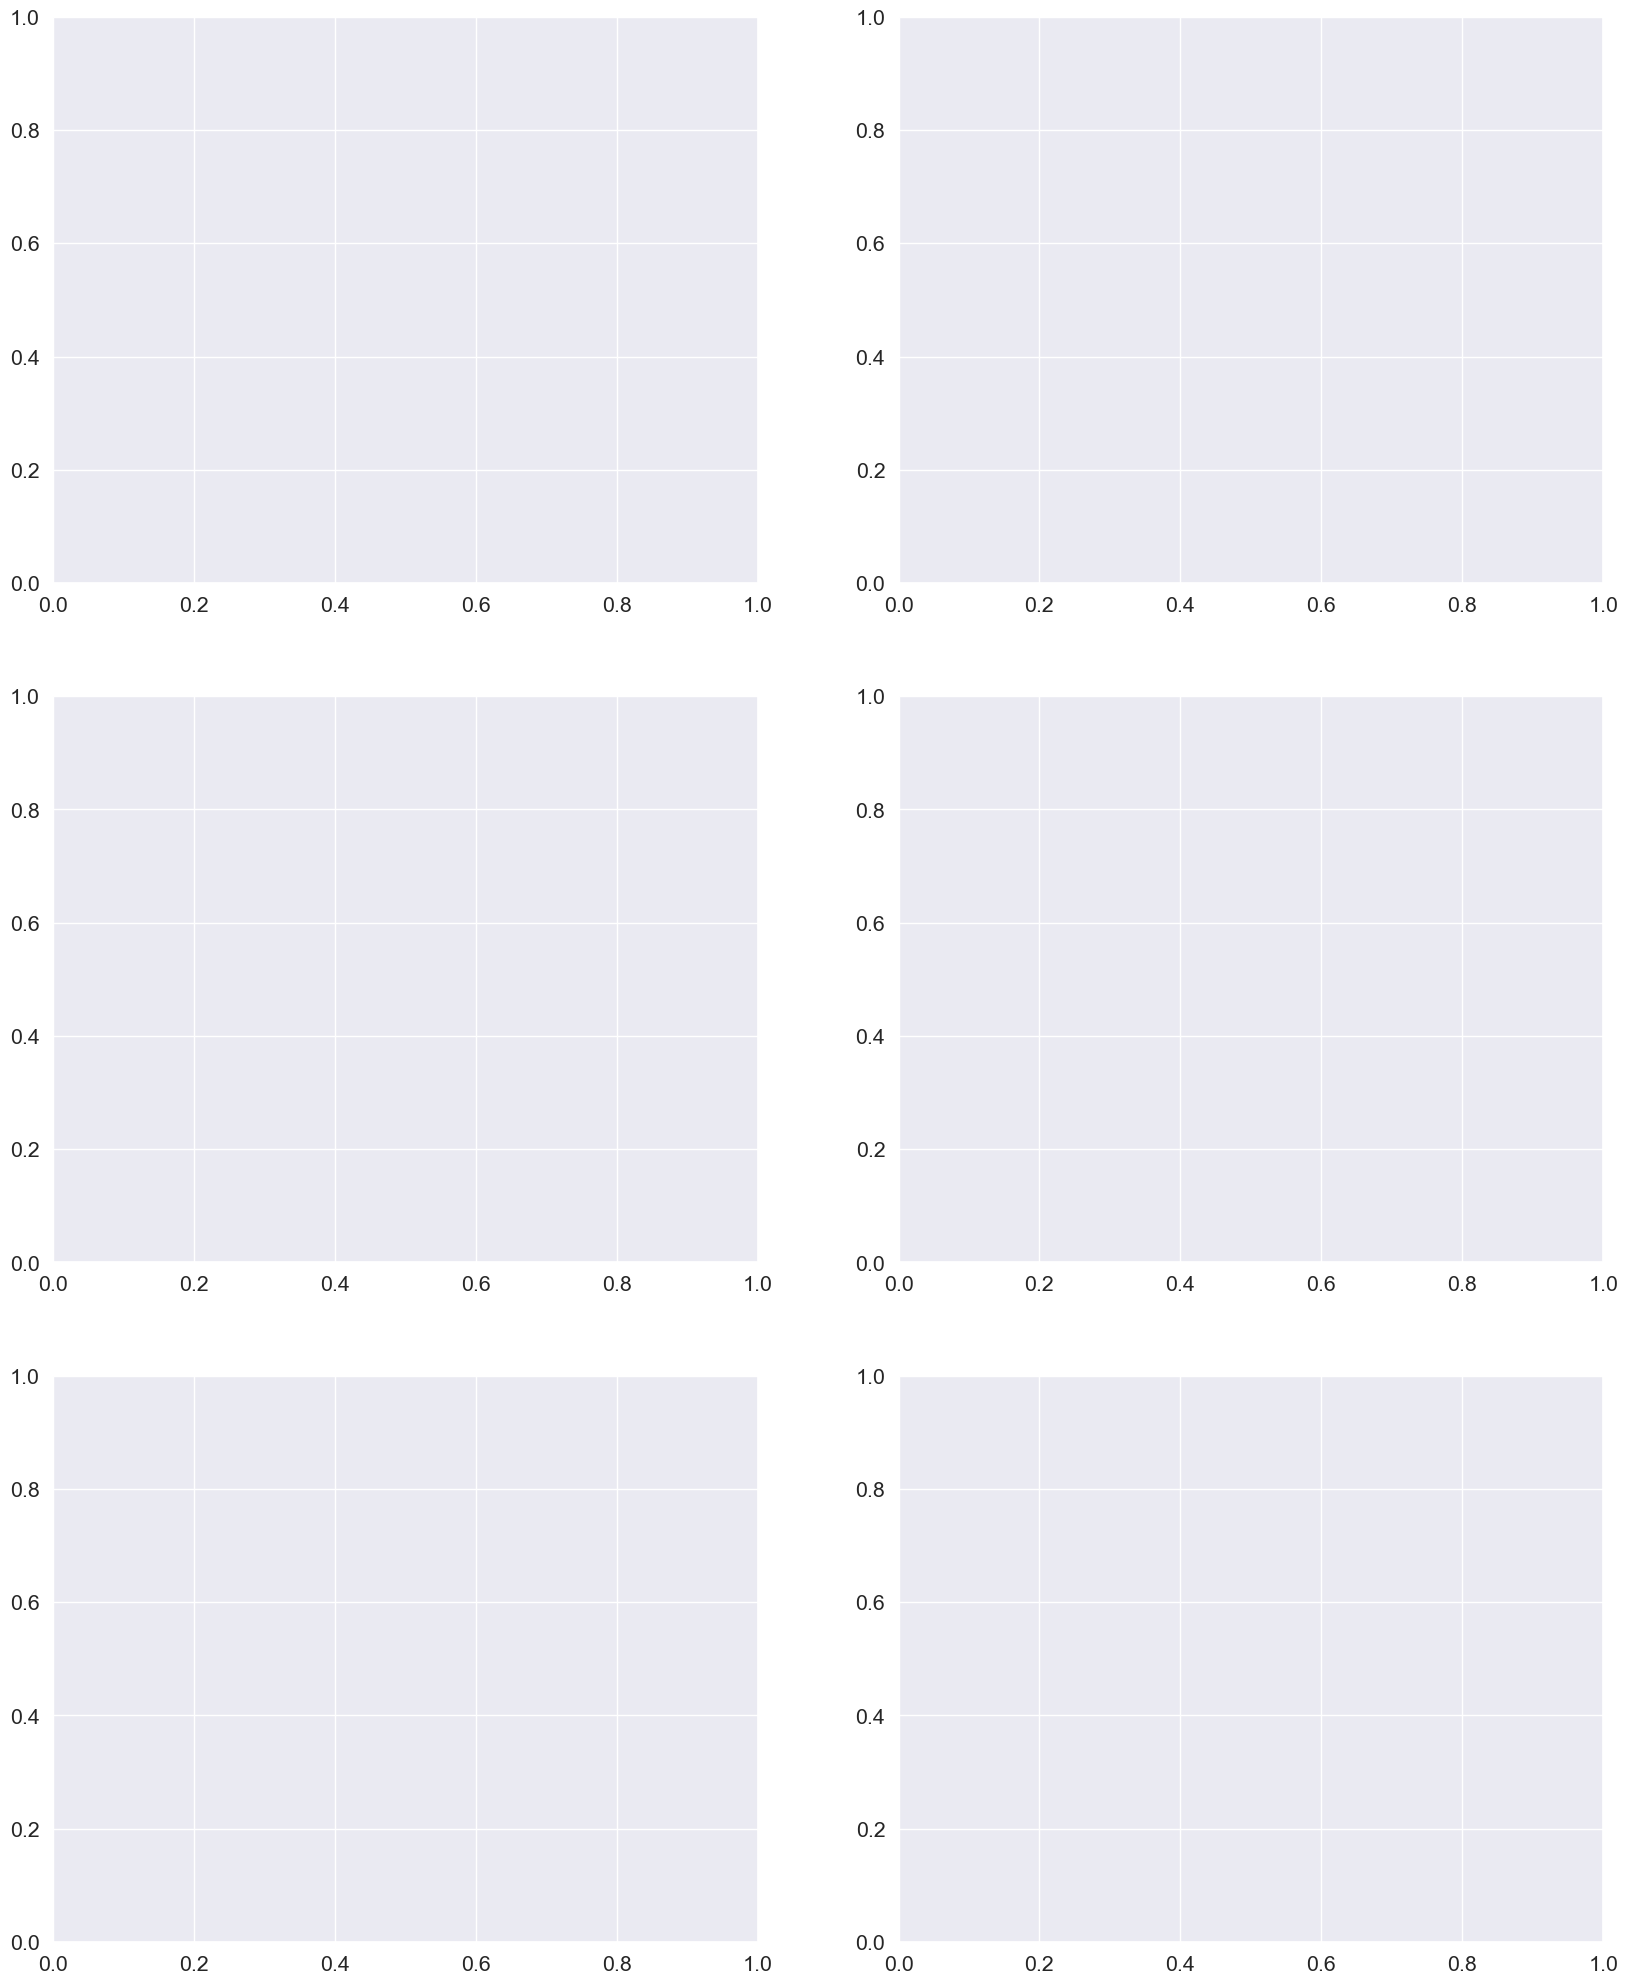

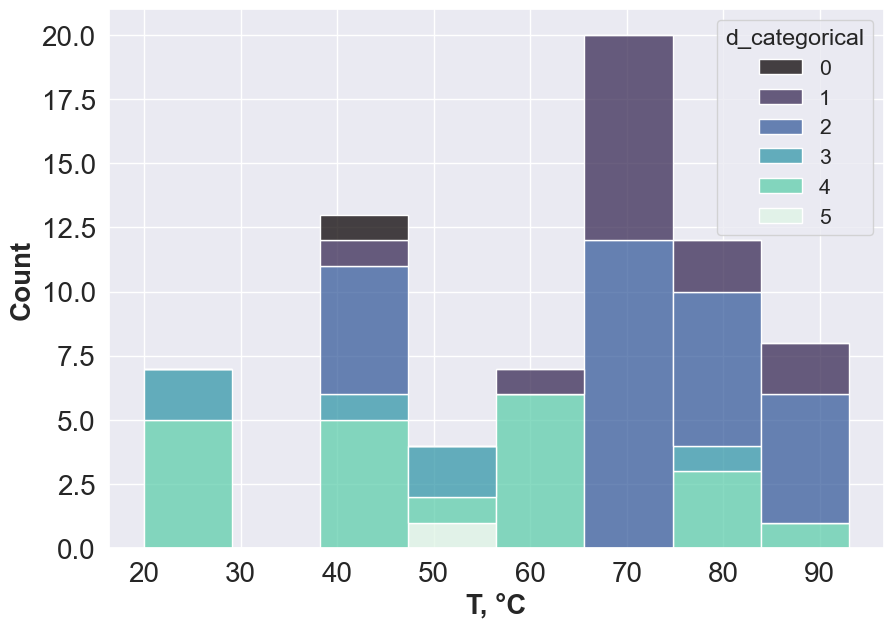

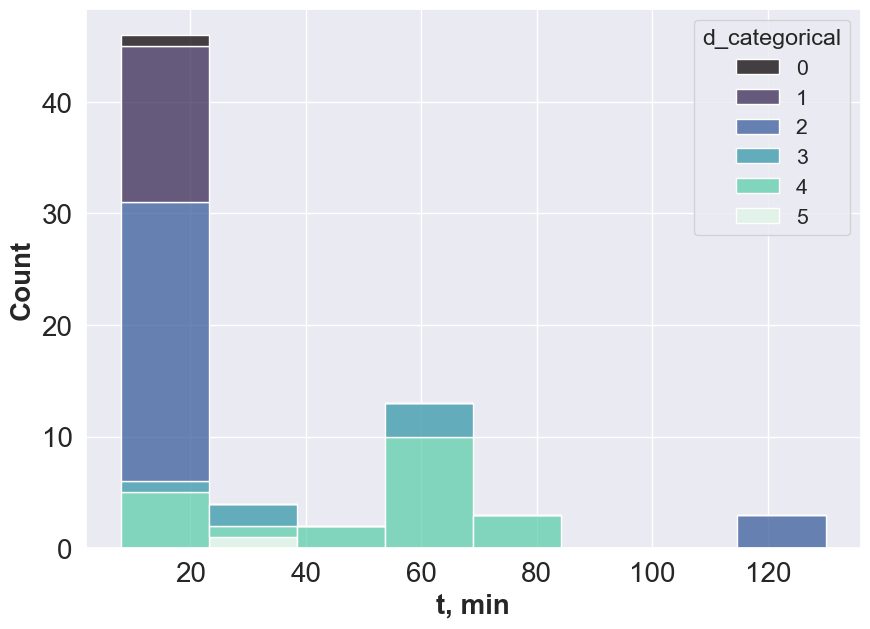

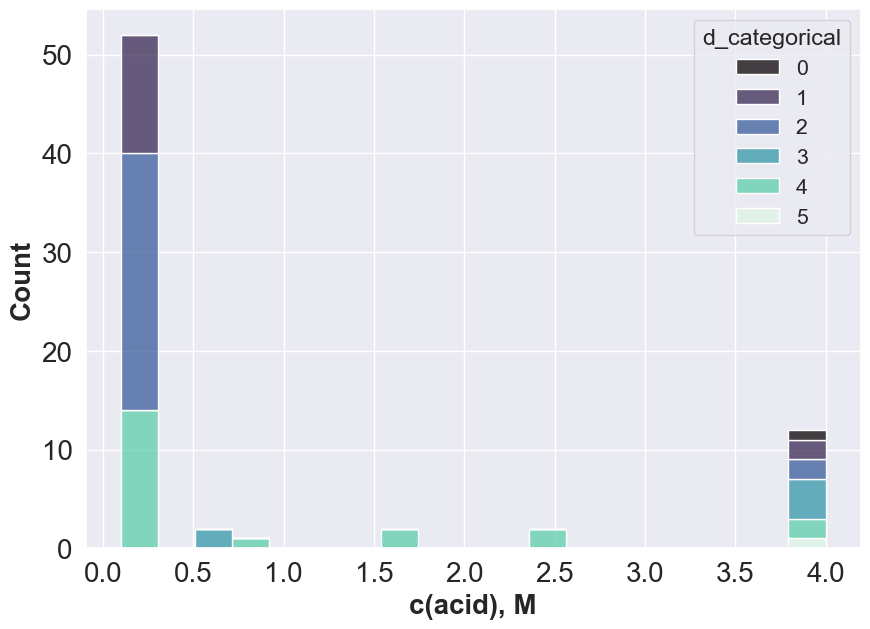

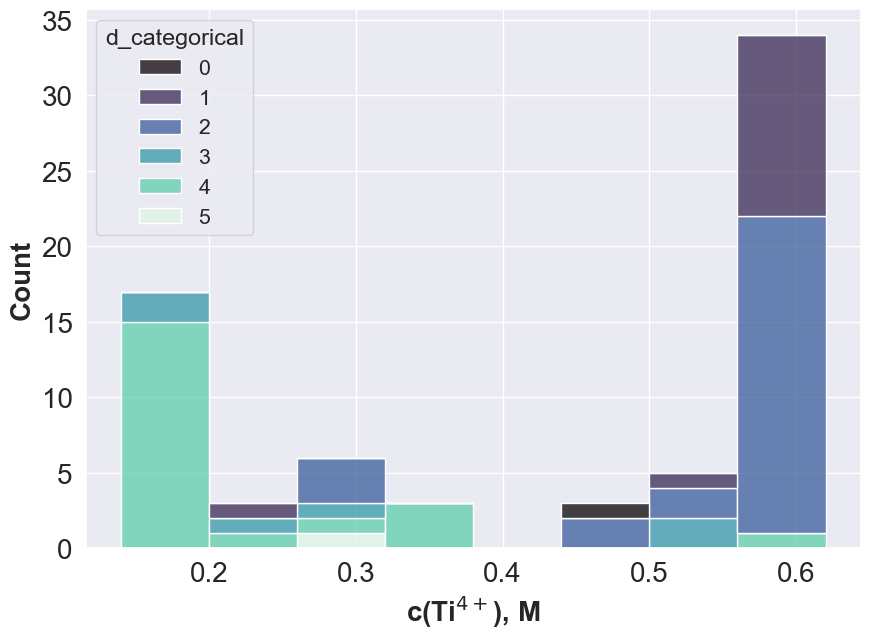

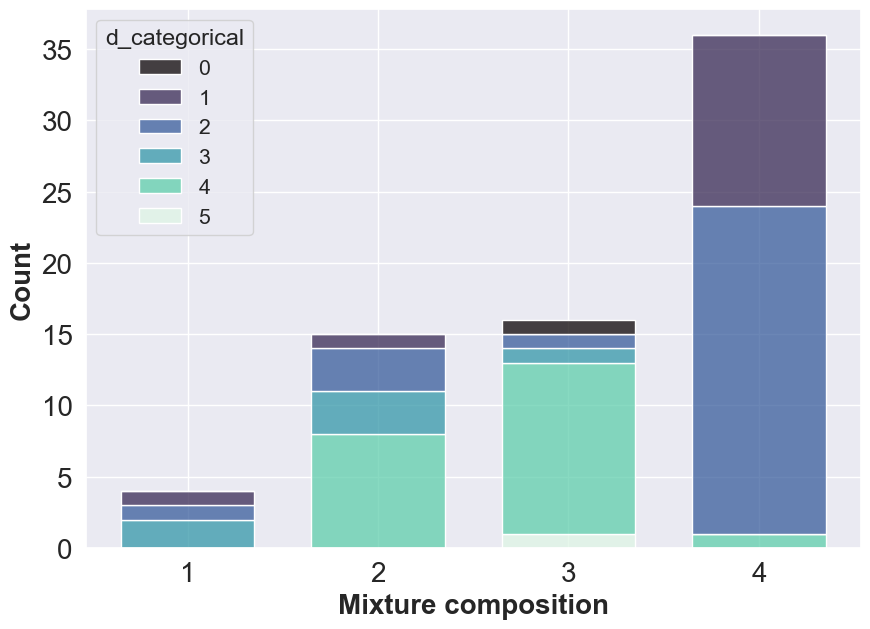

<Figure size 640x480 with 0 Axes>

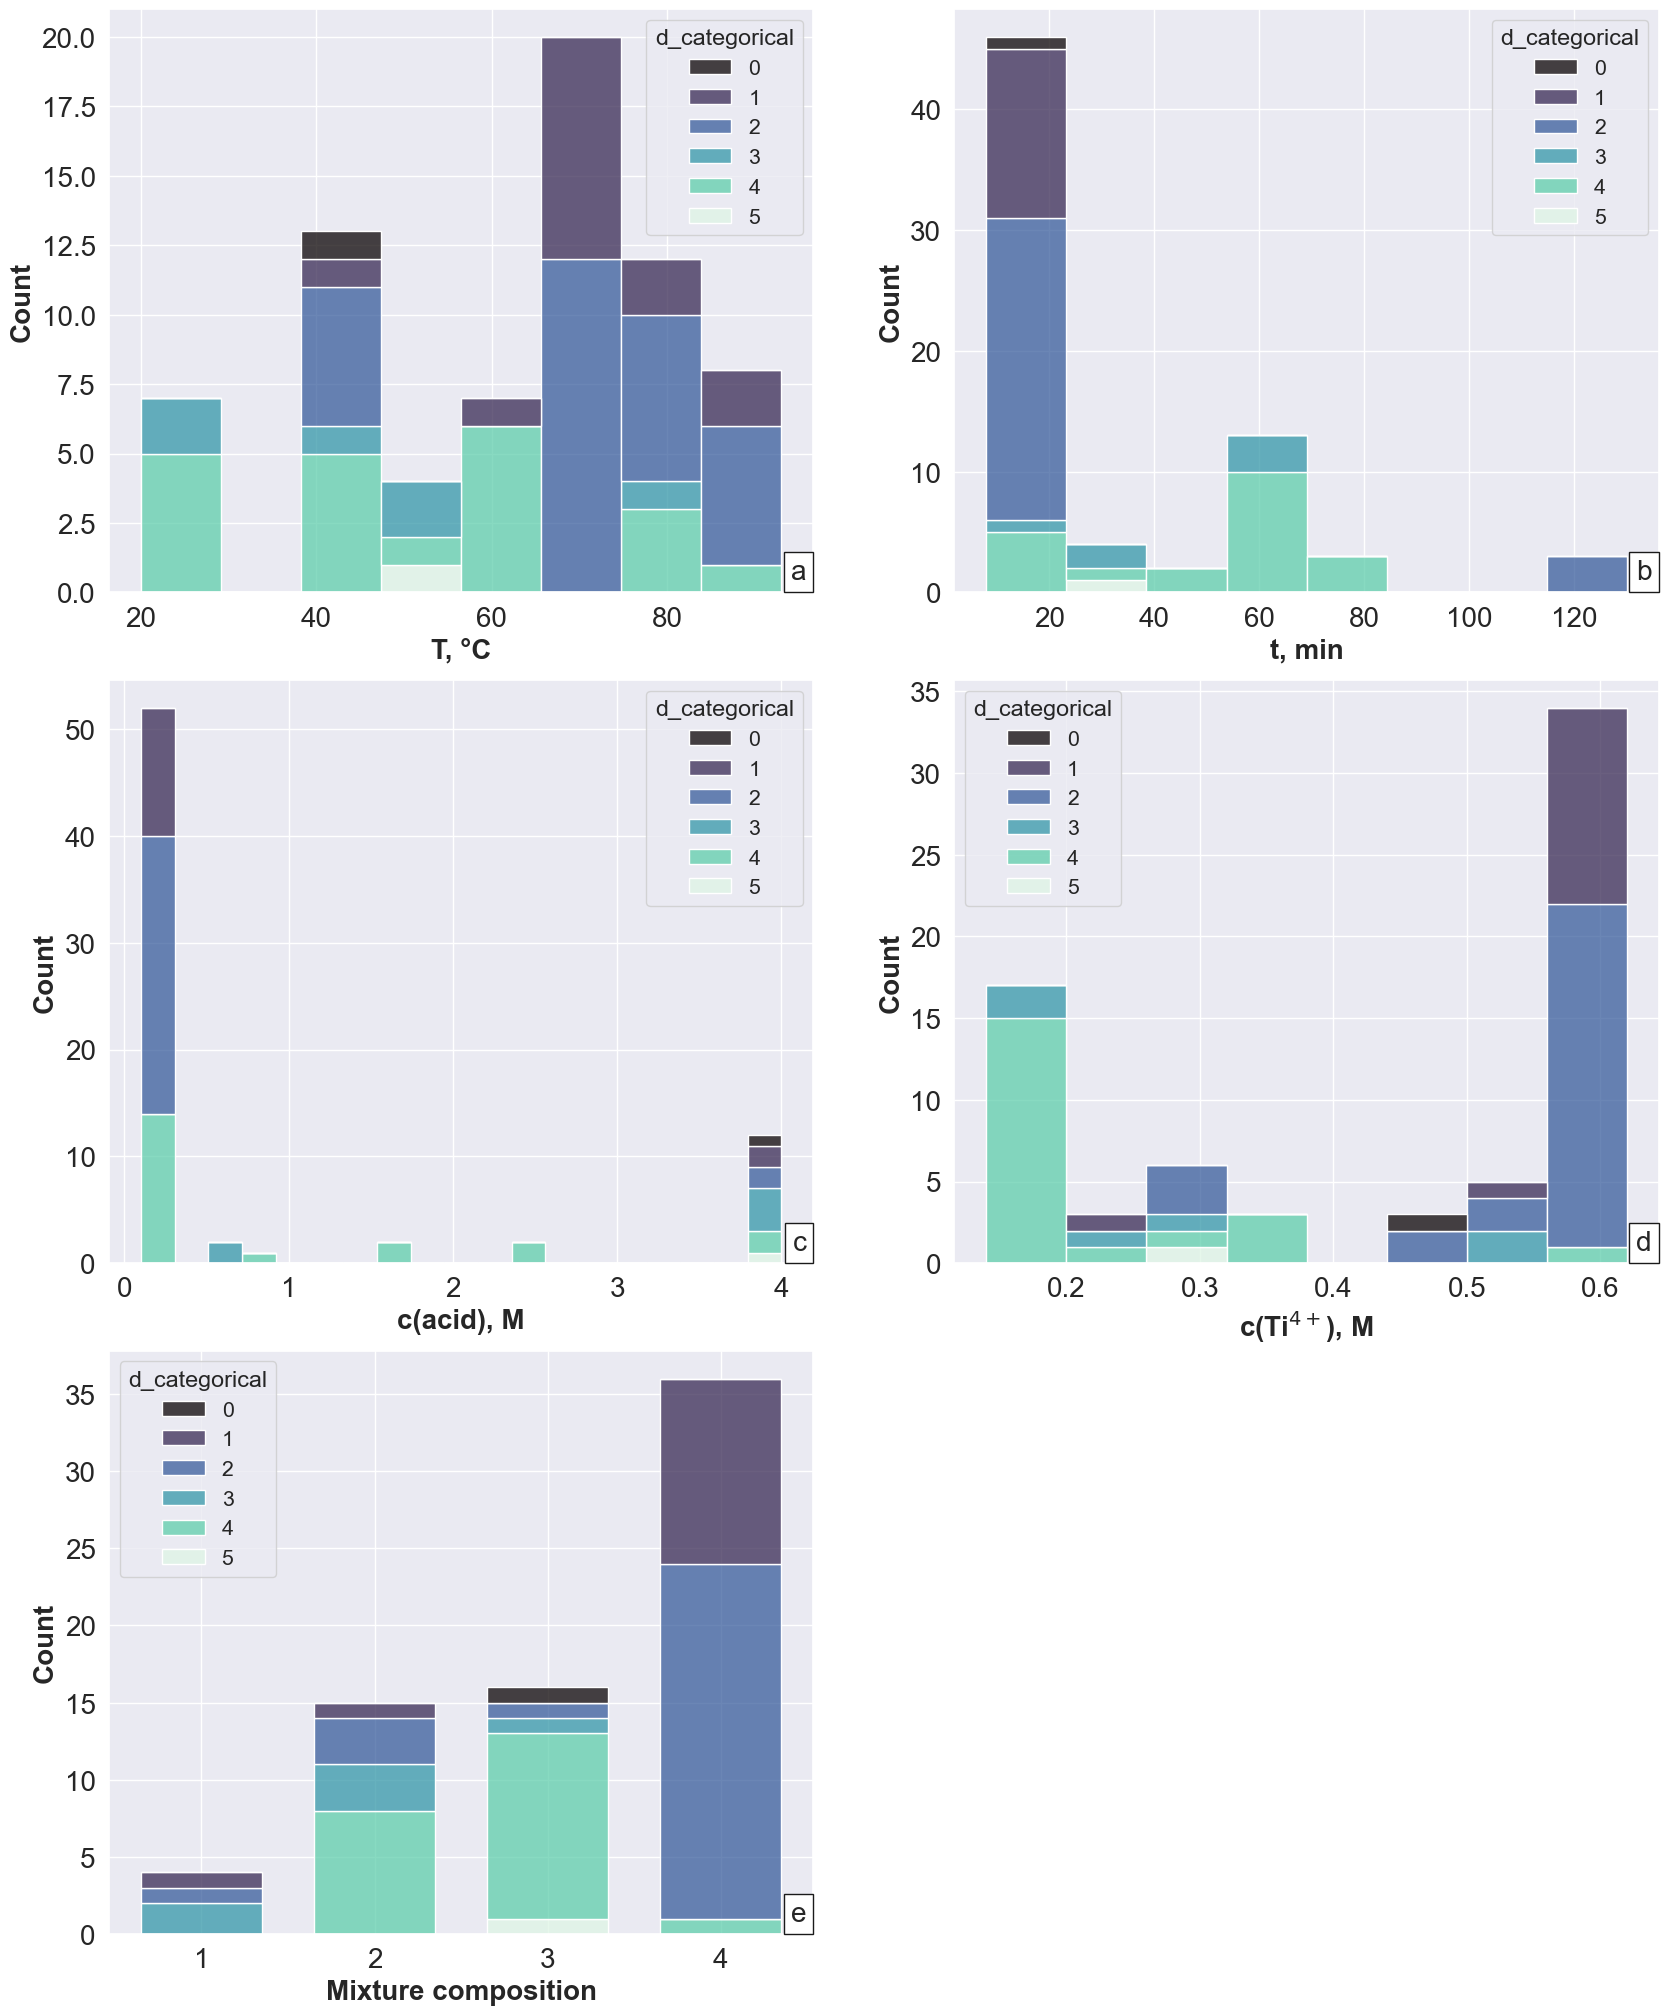

In [15]:
draw_hists(df, 'd_categorical', 'distibution_with_d_categorical', discrete_save=True)
draw_hists(df, 'd_categorical', 'distibution_with_d_categorical')

In [16]:
df_plot = df.copy(deep=True)

def replace_func_days(x):
    if x < 20:
        return "< 20"
    else:
        return str(x)

df_plot['Stability of sols, days'] = df_plot['Stability of sols, days'].apply(replace_func_days)

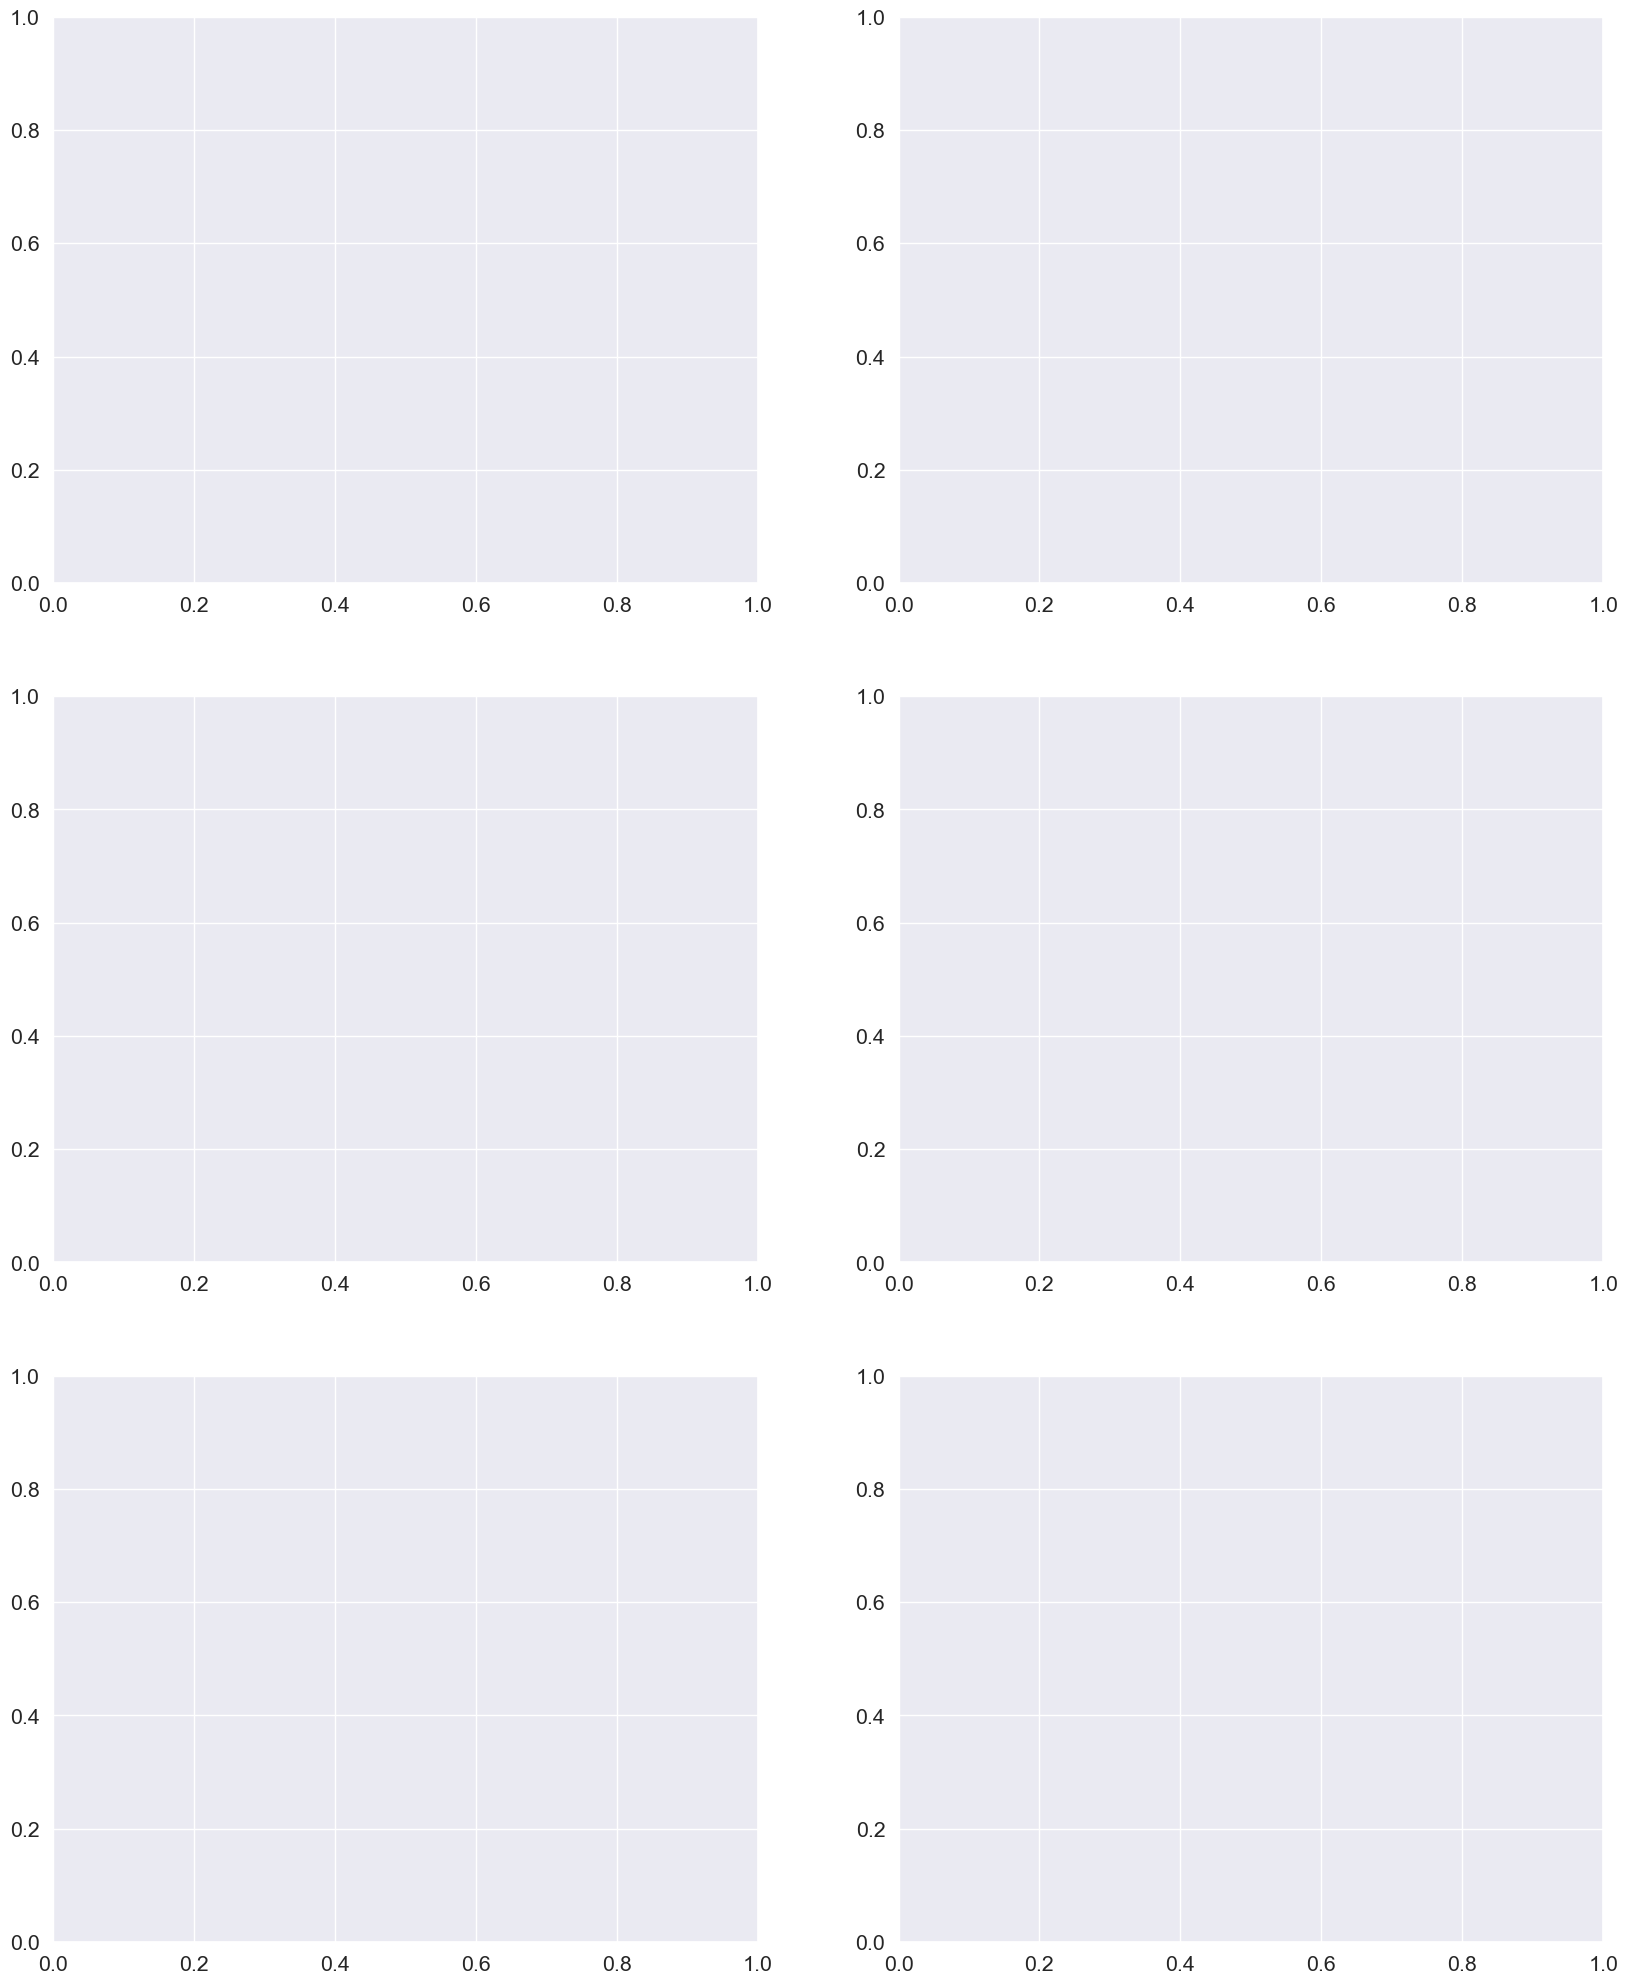

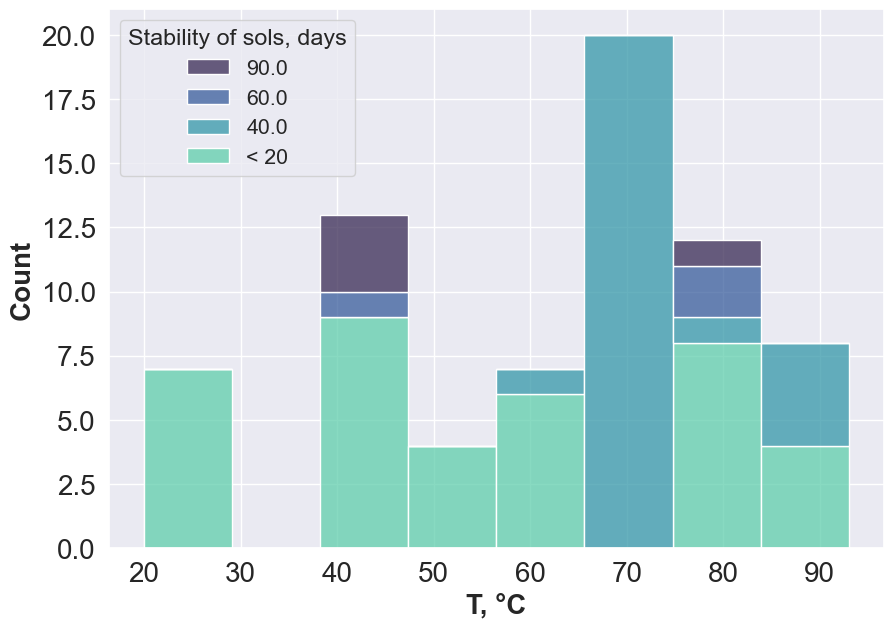

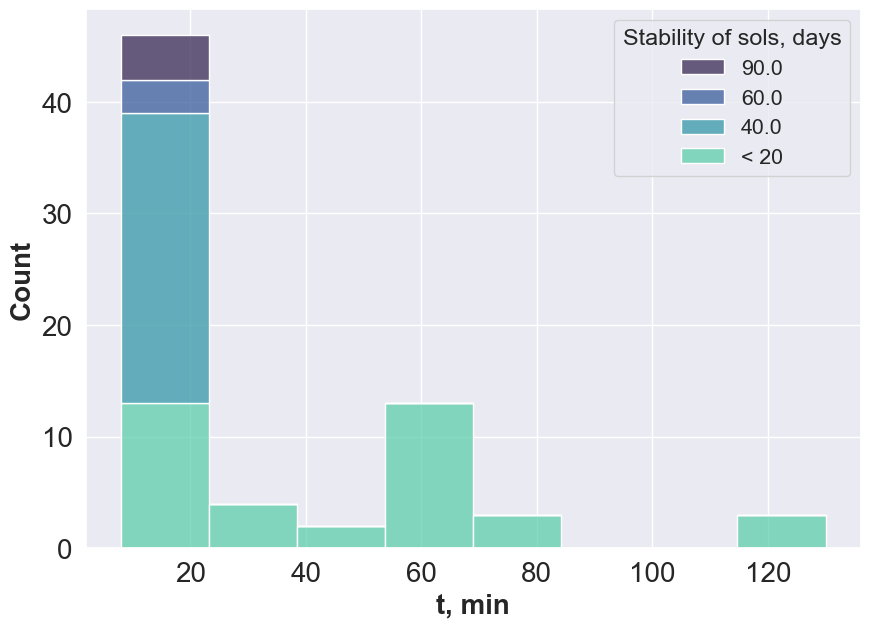

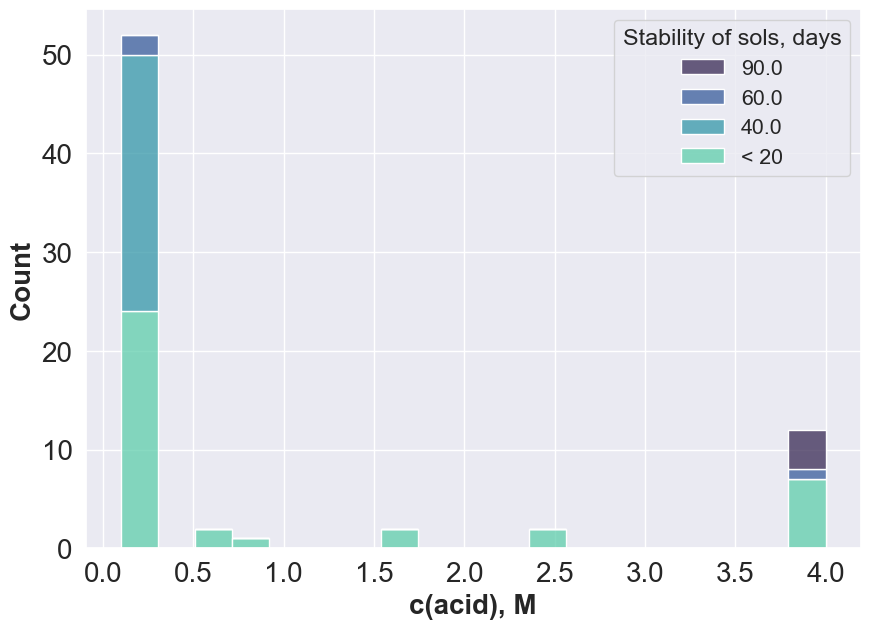

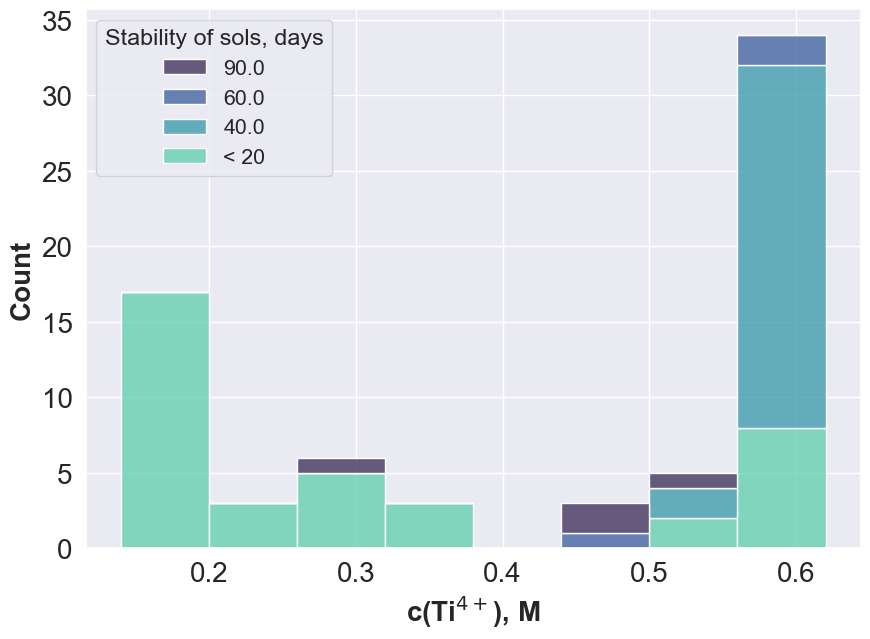

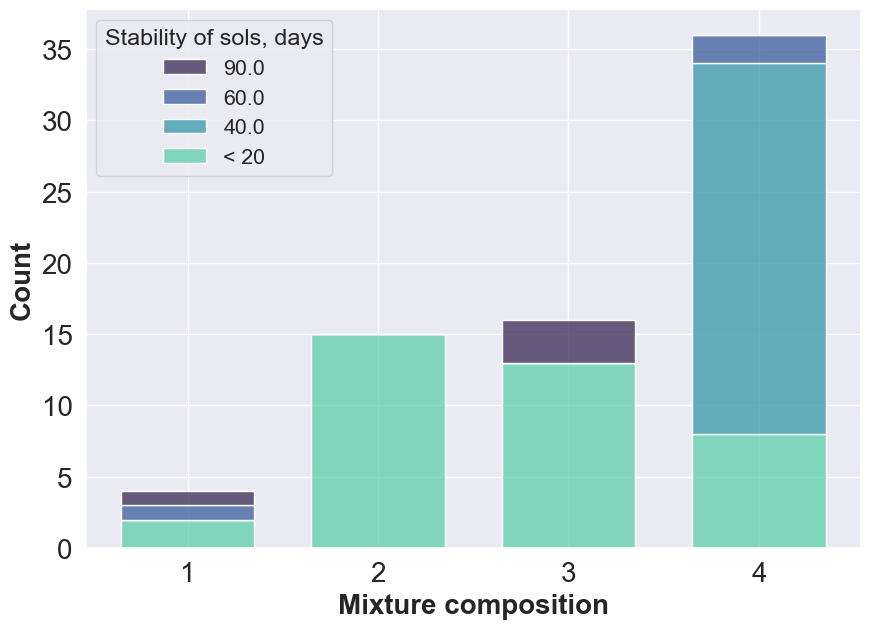

<Figure size 640x480 with 0 Axes>

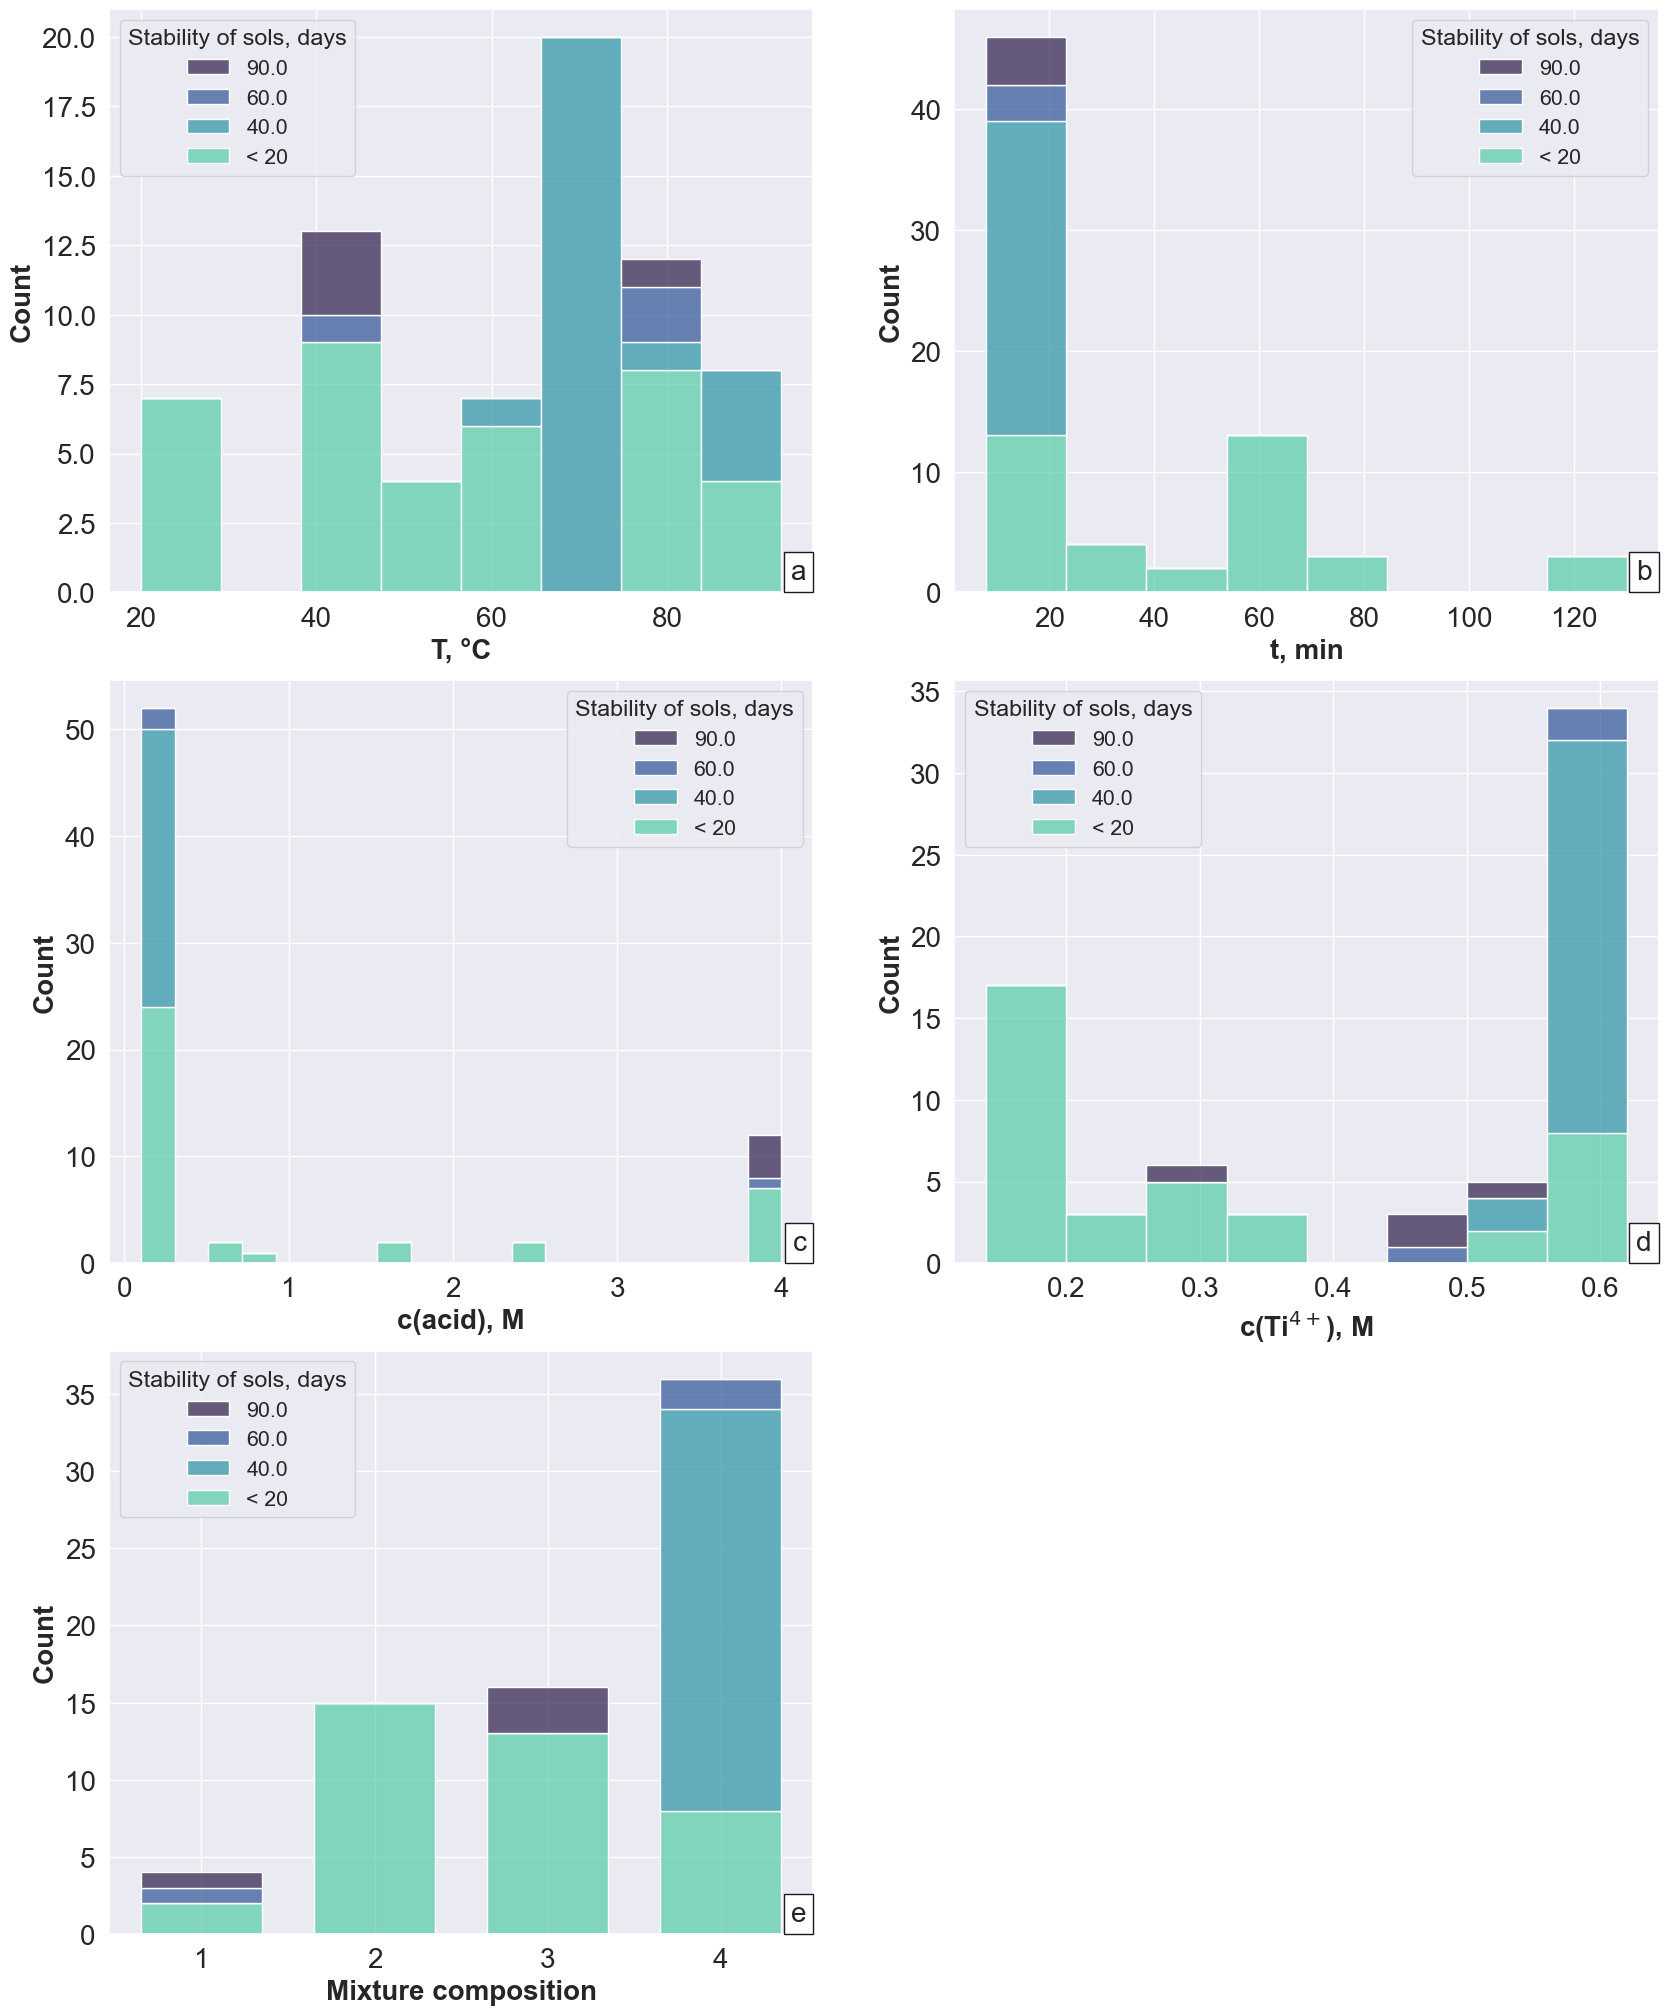

In [17]:
hue_order =['90.0', '60.0', '40.0', '< 20']
draw_hists(df_plot, 'Stability of sols, days', 'distibution_with_stability_days', hue_order=hue_order, discrete_save=True)
draw_hists(df_plot, 'Stability of sols, days', 'distibution_with_stability_days', hue_order=hue_order)

In [18]:
df_plot = df.copy(deep=True)

def replace_func_days(x):
    if x < 96:
        return "< 96"
    else:
        return str(x)

df_plot['Contents, %'] = df_plot['Contents, %'].apply(replace_func_days)

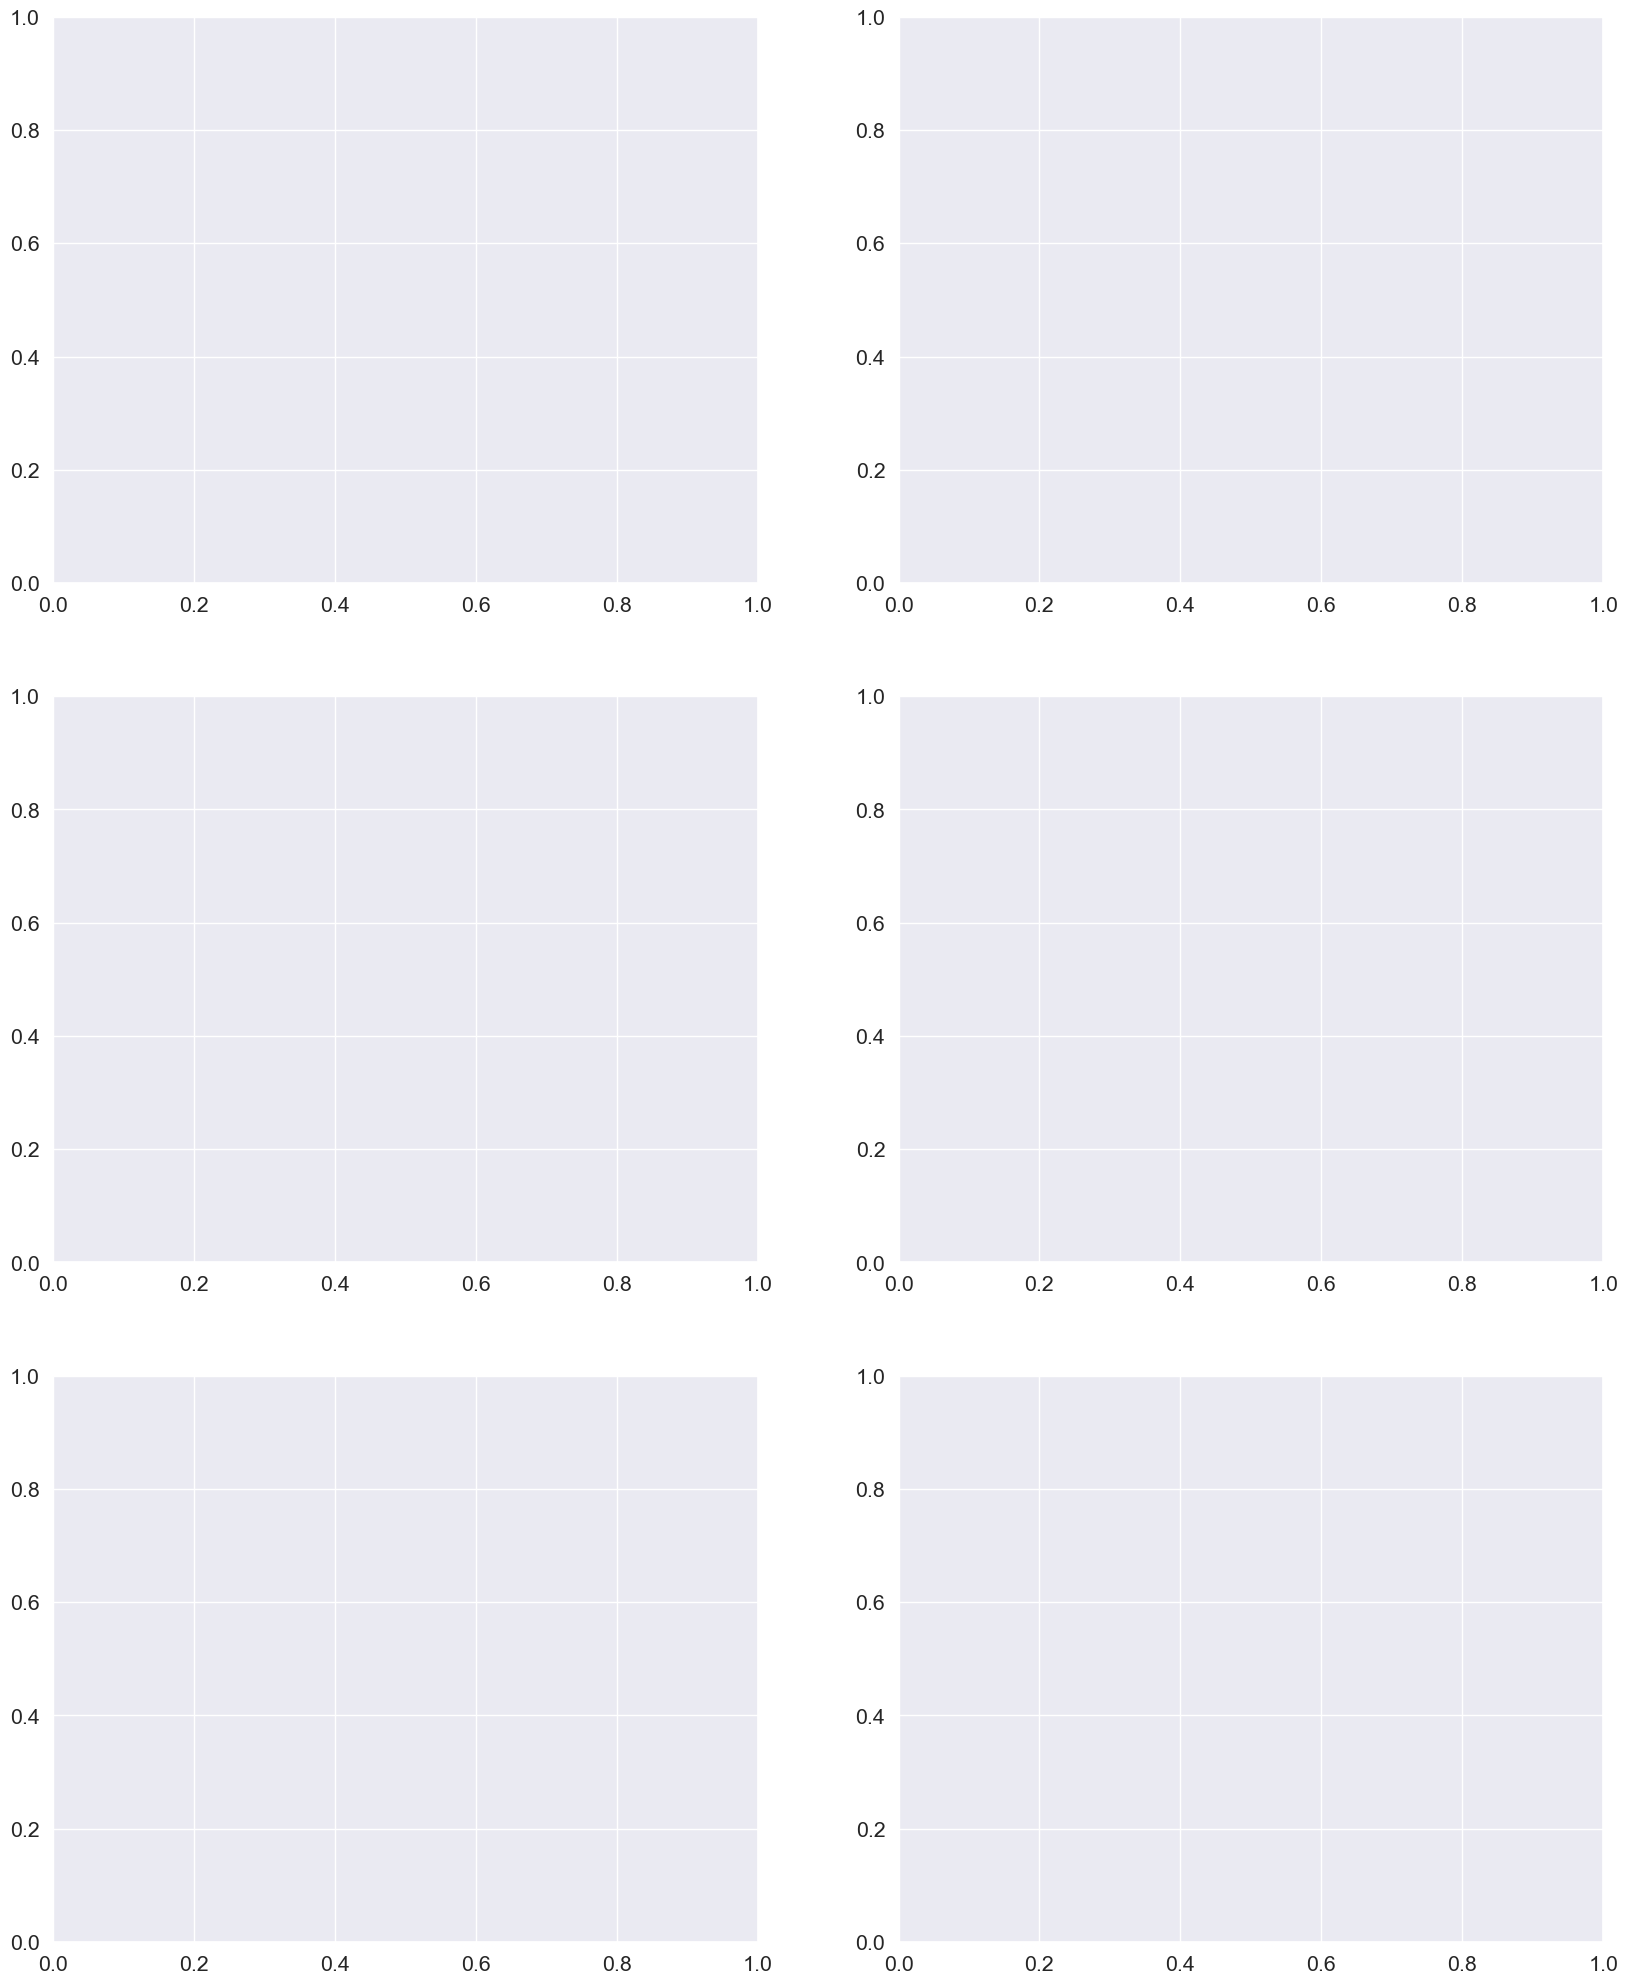

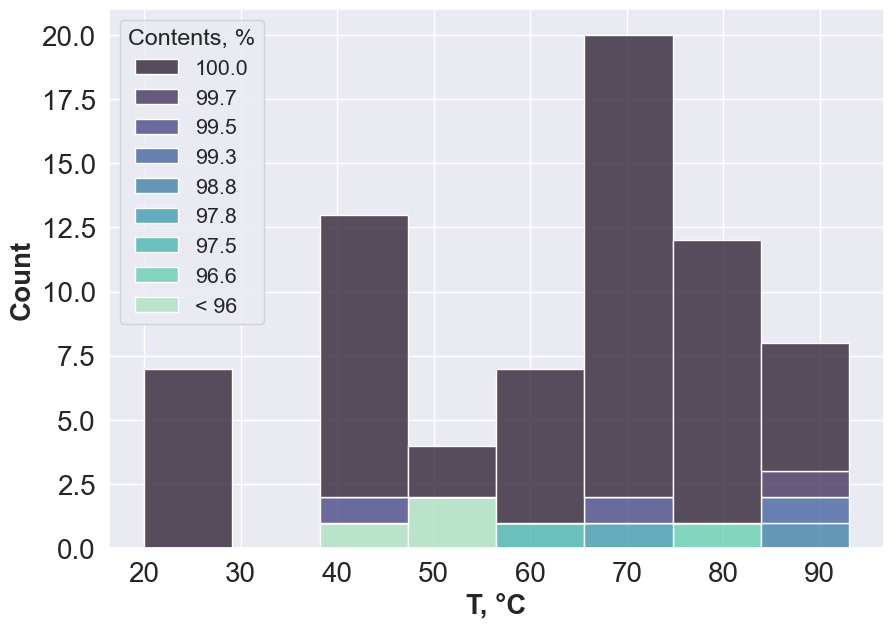

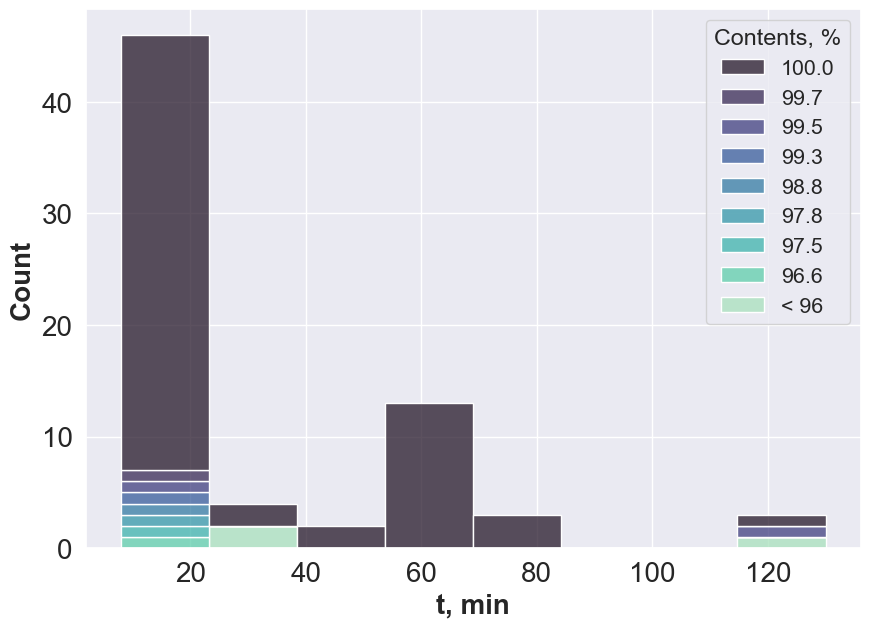

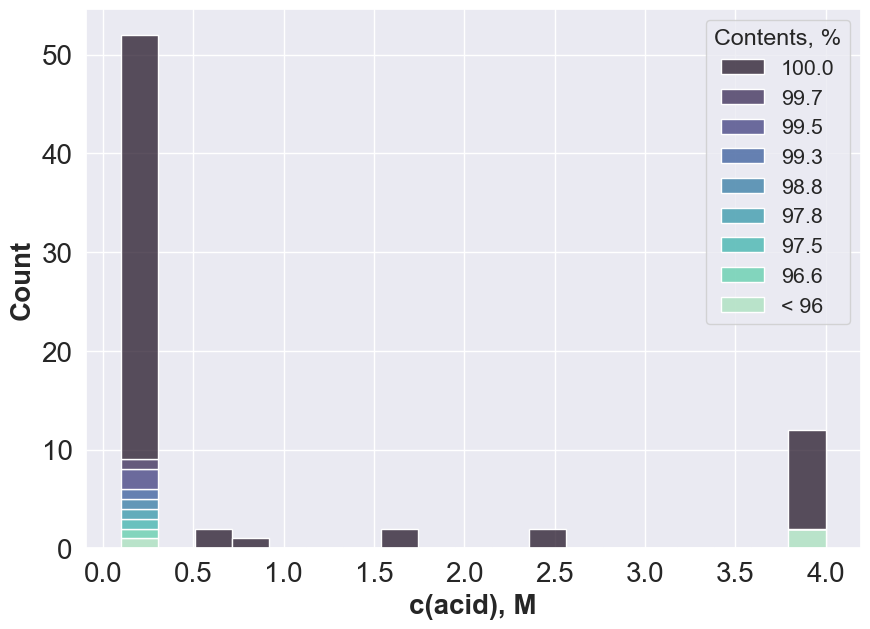

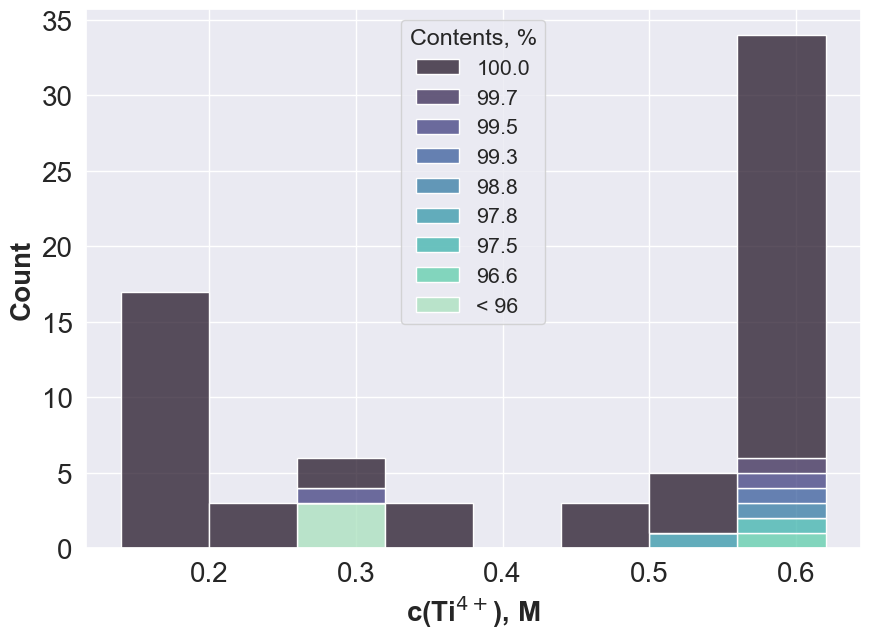

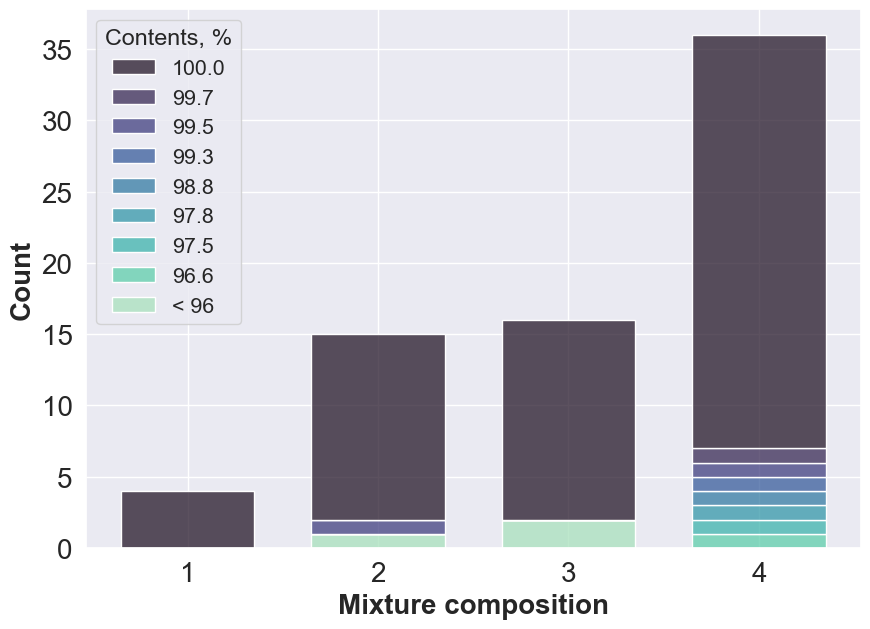

<Figure size 640x480 with 0 Axes>

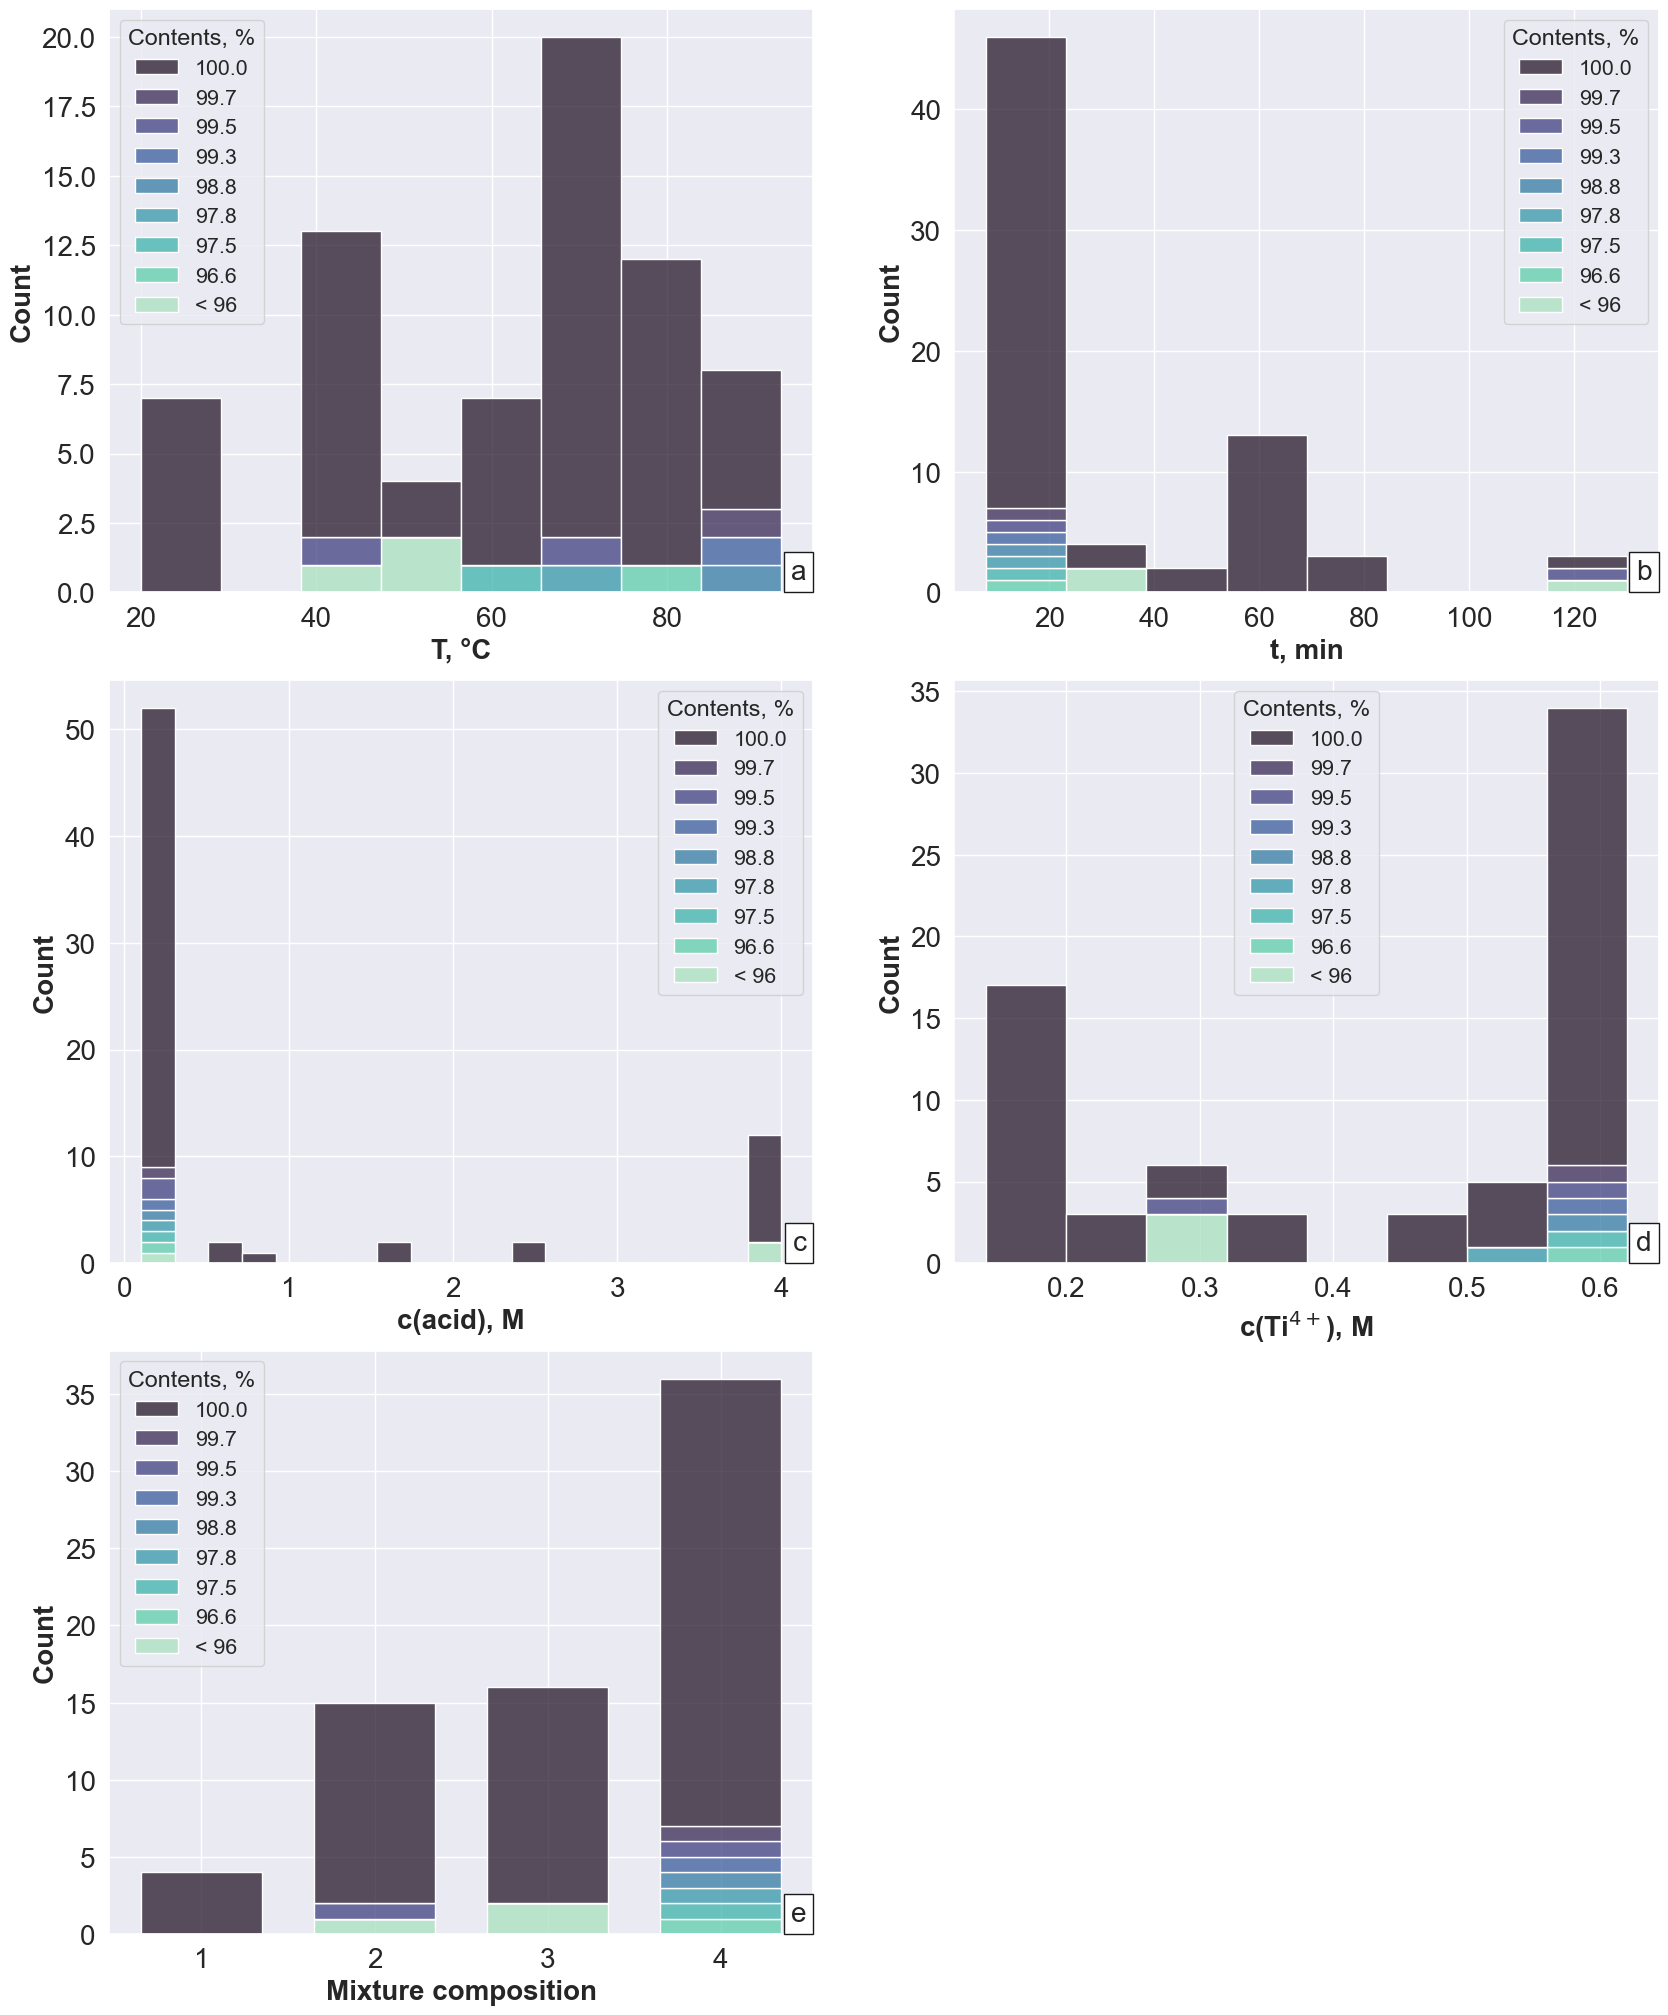

In [19]:
hue_order=['100.0', '99.7', '99.5',  '99.3',  '98.8', '97.8', '97.5', '96.6', '< 96']
draw_hists(df_plot, 'Contents, %', 'distibution_with_contents', hue_order=hue_order, discrete_save=True)
draw_hists(df_plot, 'Contents, %', 'distibution_with_contents', hue_order=hue_order)